In [18]:
import pandas as pd
import numpy as np
import helper
import missingno as msno
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import catboost as cb
import seaborn as sns

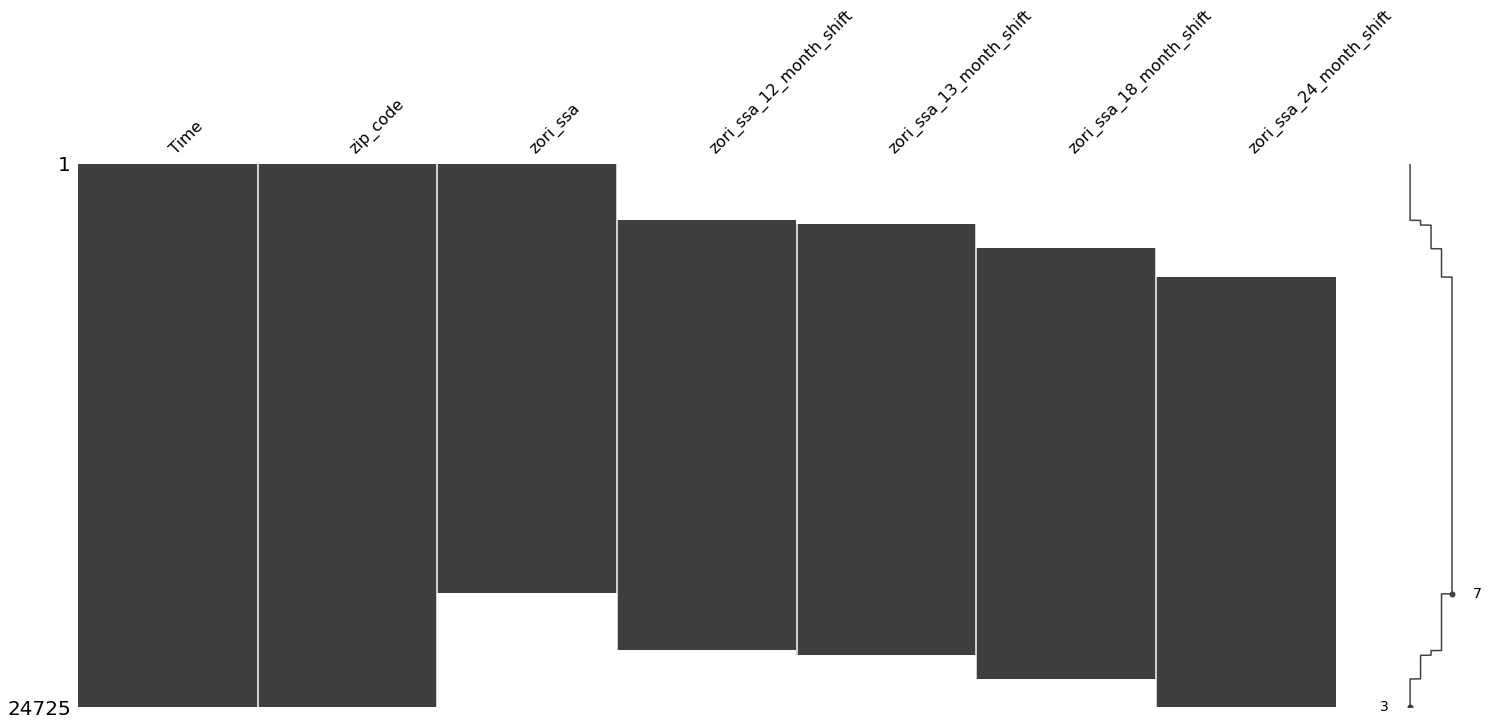

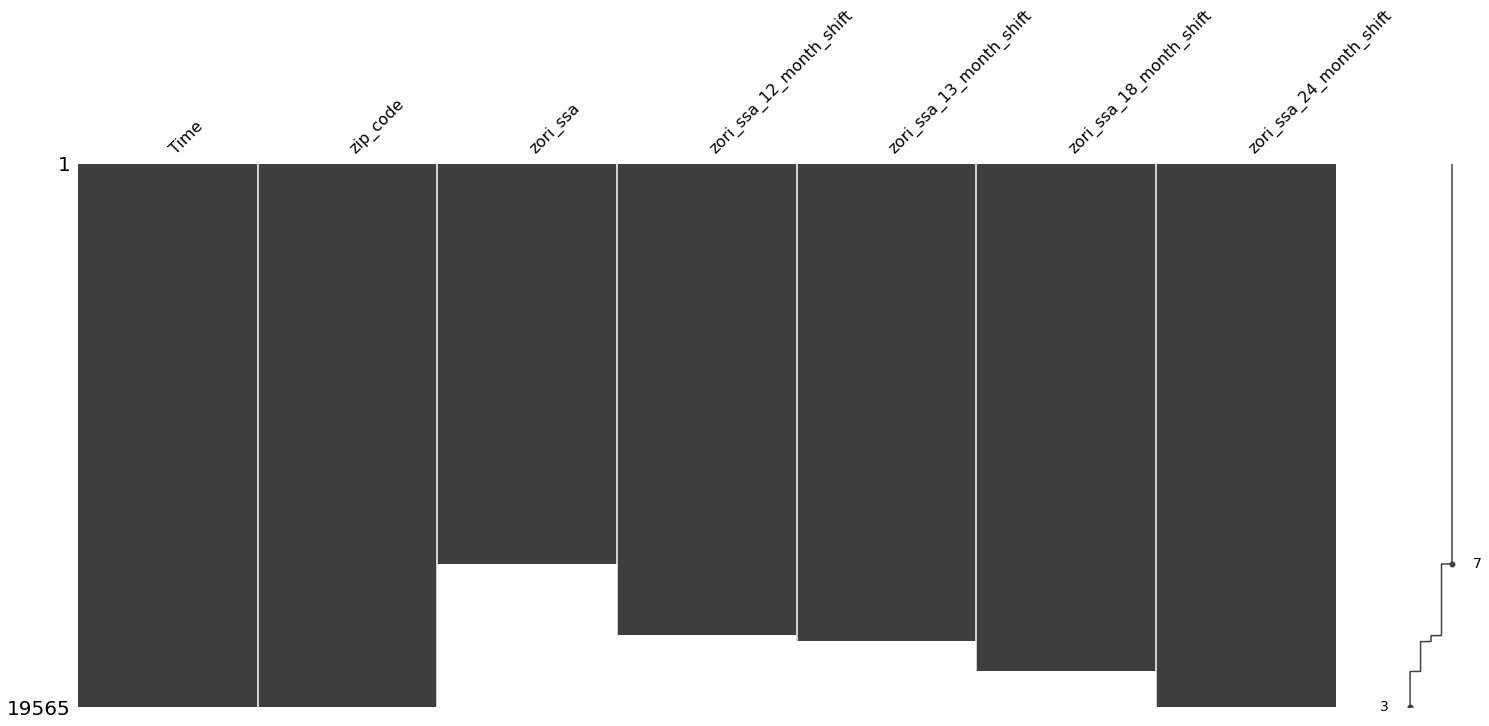

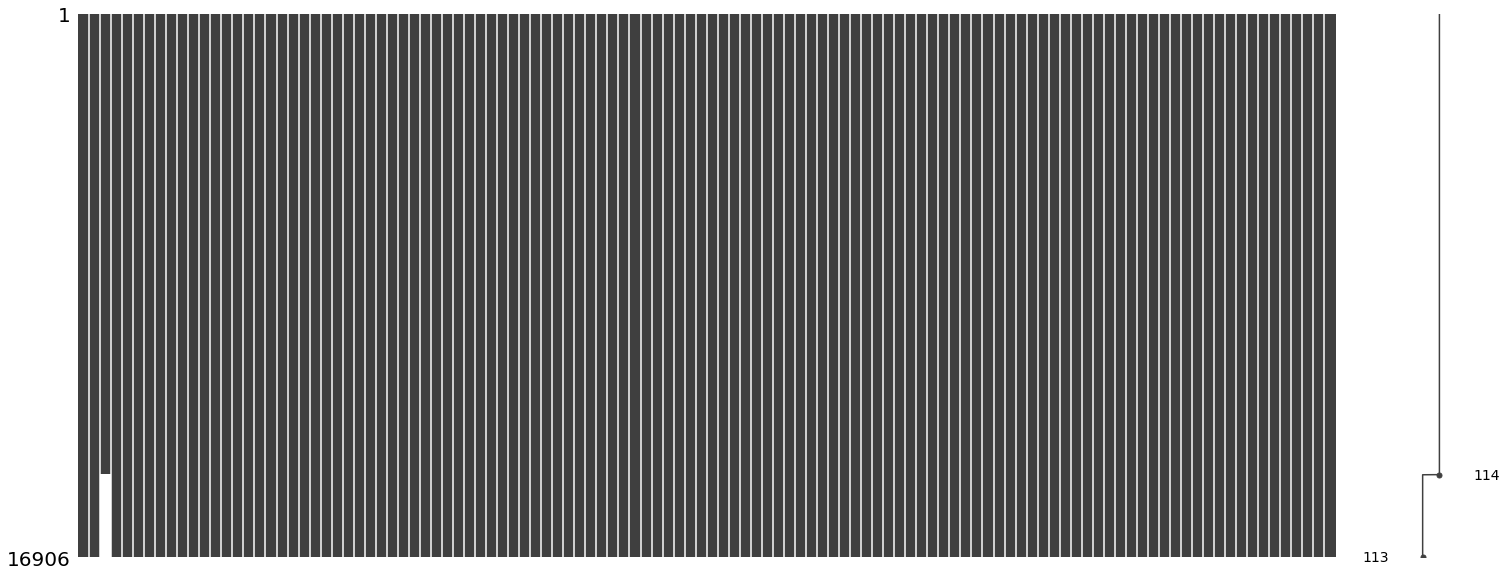

In [19]:
# load data
texas_data = pd.read_csv('cleaned_data/merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('cleaned_data/merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('cleaned_data/long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# adding shift to zri
zri_shift = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa'],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_full = True
                                         )

# there should now be extra values after our target. 
# We are gonna remove the missing values that happen at the start of our inputs tho
zri_shift = zri_shift.sort_values('Time')
msno.matrix(zri_shift)
plt.show()
zri_shift = zri_shift.dropna(subset = ['zori_ssa_24_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)
msno.matrix(zri_shift)
plt.show()
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])

zri_shift = zri_shift[['Time','zip_code','zori_ssa', 
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff_lag_12', 
                       'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12_per'
                      ]]


# merge non acs data 
extra_shift = ['Gross Value Natural Gas Production', 'sap_case_shiller_index']
merged_df = helper.time_lag_merge(zri_shift, 
                                                    texas_data, {
    12:list(texas_data.drop(columns = ['Time','zip_code']+extra_shift
                            ).columns),
    13:extra_shift
},
                                          return_full = True
                                         )
# merge acs data
acs_1_cols = [
    'black_pop',
    'white_pop',
    'hispanic_pop',
    'high_school_diploma',
    'female_female_households',
    'armed_forces',
    'children',
    'black_pop_annual_pct_change',
    'white_pop_annual_pct_change',
    'hispanic_pop_annual_pct_change',
    'high_school_diploma_annual_pct_change',
    'children_annual_pct_change',
    ]
merged_df = helper.time_lag_merge(merged_df, 
                                                    acs_data, {
    36:list(acs_data.drop(columns = ['Time','zip_code'] + acs_1_cols).columns),
    48:acs_1_cols                                              
},
                                          return_full = True
                                         )
# # visualize missing values. it should be that acs 2 does not have a single zipcode
# # then removing that line and checking to see that there are no more missing values.
merged_df = merged_df.loc[merged_df['Time']>datetime.datetime(2016,6,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.loc[merged_df['Time']<datetime.datetime(2022,7,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.sort_values('Time')
merged_df = merged_df.dropna(subset = ['single_women_36_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)

# this now should have no missing values except for the last year when 
# we are doing a forecast
msno.matrix(merged_df)
plt.show()



In [21]:
merged_df

,Time,zip_code,zori_ssa,zori_ssa_12_month_shift,zori_ssa_1_diff_lag_12,zori_ssa_6_diff_lag_12,zori_ssa_12_diff_lag_12_per,mintempC_12_month_shift,sales_tax_rate_12_month_shift,total_sales_tax_12_month_shift,...,hispanic_pop_48_month_shift,high_school_diploma_48_month_shift,female_female_households_48_month_shift,armed_forces_48_month_shift,children_48_month_shift,black_pop_annual_pct_change_48_month_shift,white_pop_annual_pct_change_48_month_shift,hispanic_pop_annual_pct_change_48_month_shift,high_school_diploma_annual_pct_change_48_month_shift,children_annual_pct_change_48_month_shift
0,2016-07-01,78728.0,1359.0,1310.0,5.0,27.0,0.041221,23.129032,1.00,15540677.65,...,5832.0,2326.0,36.0,66.0,4372.0,-0.053767,0.099366,0.047790,-0.410192,0.087833
1,2016-07-01,77385.0,1338.0,1342.0,1.0,11.0,0.035768,24.838710,2.00,3214141.01,...,3216.0,2040.0,15.0,14.0,5160.0,-0.341905,0.035431,0.171585,-0.483986,-0.030257
2,2016-07-01,77006.0,1688.0,1708.0,1.0,8.0,0.014637,24.838710,1.00,50726415.46,...,3816.0,1681.0,87.0,16.0,1668.0,-0.062078,-0.016447,-0.062638,-0.575089,-0.115589
3,2016-07-01,75149.0,1231.0,1159.0,5.0,30.0,0.058671,25.387097,2.00,2953001.40,...,19264.0,8691.0,26.0,16.0,17517.0,0.118383,-0.080867,0.022831,1.189408,0.003150
4,2016-07-01,78240.0,991.0,907.0,-3.0,-14.0,0.012128,23.483871,1.25,23634473.35,...,24430.0,5169.0,129.0,205.0,10767.0,0.156291,-0.008041,0.017874,0.309539,0.057870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16901,2022-07-01,78245.0,NaN,1323.0,8.0,48.0,0.056689,23.967742,1.25,34095898.97,...,50722.0,9729.0,33.0,1373.0,23718.0,0.128059,0.077674,0.040836,0.008291,0.038851
16902,2022-07-01,77429.0,NaN,1647.0,13.0,75.0,0.077110,25.354839,1.00,61906006.57,...,16951.0,7941.0,52.0,16.0,27346.0,0.023217,0.013786,0.048105,-0.008985,0.014468
16903,2022-07-01,75052.0,NaN,1558.0,14.0,83.0,0.096277,25.903226,1.75,5357538.76,...,34422.0,12674.0,25.0,45.0,26021.0,0.009034,-0.005982,-0.000900,0.042013,0.005099
16904,2022-07-01,78741.0,NaN,1394.0,9.0,52.0,0.056671,23.741935,1.00,23319605.65,...,27707.0,5360.0,47.0,10.0,9626.0,0.063220,0.084575,-0.027244,0.006762,-0.008242


In [22]:
# creating list of variables to put into the model. initialy is all non index and target
X_vals = merged_df.drop(['Time', 'zip_code', 'zori_ssa'], axis=1).columns.to_list()
# then remove variables that don't work for that given model.
bad_X_vals = [
             ]
X_vals = [X_val for X_val in X_vals if X_val not in bad_X_vals]
y_val = 'zori_ssa'
# then remove variables that don't work for that given model.
bad_X_vals = [
    # features that you don't like that you can remove

             ]
X_vals = [X_val for X_val in X_vals if X_val not in bad_X_vals]
y_val = 'zori_ssa'

# split train and test based on a year in advance.
train = merged_df.loc[merged_df['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
post_train = merged_df.loc[merged_df['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
test = post_train.loc[post_train['Time']<datetime.datetime(2021,7,2),:].reset_index(drop=True)
forecast = post_train.loc[post_train['Time']>datetime.datetime(2021,7,2),:].reset_index(drop=True)

# set up x and y values with a scaler
# train first
scaler = StandardScaler(with_mean=False)
X = train[X_vals]
X = scaler.fit_transform(X)
y = train[y_val]
# test second
X_test = test[X_vals]
X_test = scaler.transform(X_test)
y_test = test[y_val]
# forecasted values
X_forecast = forecast[X_vals]
X_forecast = scaler.transform(X_forecast)

In [23]:
### Run Catboost - non ACS data, no priors
# Testing performance
# RMSE: 58.14781736264256
# R2: 0.9473769053432111
# l2_leaf_ref: 1
# iterations: 250
# depth: 4
# learning_rate: 0.5

train_dataset = cb.Pool(X, y)
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor(loss_function='RMSE', verbose=None)
grid = {'iterations': [150, 200, 250], 
       'learning_rate': [0.05, 0.3, 0.5], 
       'depth': [6,8], 
       'l2_leaf_reg': [0.5, 0.75, 1]}

model.grid_search(grid, train_dataset, verbose=False)
# feat_names = X_test.columns.to_list()



0:	learn: 1311.9418793	test: 1315.0779965	best: 1315.0779965 (0)	total: 24.2ms	remaining: 3.6s
1:	learn: 1248.4430526	test: 1251.4710352	best: 1251.4710352 (1)	total: 37.1ms	remaining: 2.75s
2:	learn: 1186.9969075	test: 1189.9698127	best: 1189.9698127 (2)	total: 48.9ms	remaining: 2.4s
3:	learn: 1129.9869051	test: 1132.9453259	best: 1132.9453259 (3)	total: 59.3ms	remaining: 2.17s
4:	learn: 1074.5257005	test: 1077.6877970	best: 1077.6877970 (4)	total: 70.1ms	remaining: 2.03s
5:	learn: 1022.1040953	test: 1025.0089618	best: 1025.0089618 (5)	total: 80.9ms	remaining: 1.94s
6:	learn: 973.2142836	test: 976.1168913	best: 976.1168913 (6)	total: 92.4ms	remaining: 1.89s
7:	learn: 925.7903541	test: 928.6767120	best: 928.6767120 (7)	total: 106ms	remaining: 1.88s
8:	learn: 880.5771017	test: 883.2453285	best: 883.2453285 (8)	total: 122ms	remaining: 1.91s
9:	learn: 838.8158475	test: 841.5228517	best: 841.5228517 (9)	total: 136ms	remaining: 1.9s
10:	learn: 798.2613057	test: 800.9810610	best: 800.9810610

104:	learn: 26.0569273	test: 27.3284424	best: 27.3284424 (104)	total: 1.03s	remaining: 443ms
105:	learn: 25.8061555	test: 27.0649572	best: 27.0649572 (105)	total: 1.04s	remaining: 434ms
106:	learn: 25.5543929	test: 26.8405500	best: 26.8405500 (106)	total: 1.05s	remaining: 423ms
107:	learn: 25.3222840	test: 26.6261088	best: 26.6261088 (107)	total: 1.06s	remaining: 414ms
108:	learn: 25.1071381	test: 26.4056817	best: 26.4056817 (108)	total: 1.08s	remaining: 406ms
109:	learn: 24.8907851	test: 26.1770027	best: 26.1770027 (109)	total: 1.09s	remaining: 397ms
110:	learn: 24.6813194	test: 25.9741121	best: 25.9741121 (110)	total: 1.1s	remaining: 388ms
111:	learn: 24.4851931	test: 25.7647321	best: 25.7647321 (111)	total: 1.11s	remaining: 377ms
112:	learn: 24.2988730	test: 25.5779000	best: 25.5779000 (112)	total: 1.12s	remaining: 366ms
113:	learn: 24.1226564	test: 25.4041304	best: 25.4041304 (113)	total: 1.14s	remaining: 359ms
114:	learn: 23.9546498	test: 25.2382685	best: 25.2382685 (114)	total: 1

56:	learn: 18.2541130	test: 20.2257049	best: 20.2257049 (56)	total: 514ms	remaining: 838ms
57:	learn: 18.0563206	test: 20.0121283	best: 20.0121283 (57)	total: 523ms	remaining: 830ms
58:	learn: 17.8667618	test: 19.7977343	best: 19.7977343 (58)	total: 534ms	remaining: 824ms
59:	learn: 17.7480445	test: 19.6908843	best: 19.6908843 (59)	total: 545ms	remaining: 818ms
60:	learn: 17.5985530	test: 19.5747732	best: 19.5747732 (60)	total: 555ms	remaining: 809ms
61:	learn: 17.4088866	test: 19.3791008	best: 19.3791008 (61)	total: 563ms	remaining: 799ms
62:	learn: 17.2156931	test: 19.2330572	best: 19.2330572 (62)	total: 573ms	remaining: 791ms
63:	learn: 17.0310280	test: 19.0776468	best: 19.0776468 (63)	total: 582ms	remaining: 782ms
64:	learn: 16.8675077	test: 18.9807320	best: 18.9807320 (64)	total: 589ms	remaining: 771ms
65:	learn: 16.6726576	test: 18.8682197	best: 18.8682197 (65)	total: 598ms	remaining: 761ms
66:	learn: 16.5584040	test: 18.7720862	best: 18.7720862 (66)	total: 606ms	remaining: 751ms

12:	learn: 38.5013861	test: 39.7446936	best: 39.7446936 (12)	total: 118ms	remaining: 1.24s
13:	learn: 37.4842574	test: 38.5864020	best: 38.5864020 (13)	total: 128ms	remaining: 1.24s
14:	learn: 36.3712833	test: 37.4724955	best: 37.4724955 (14)	total: 137ms	remaining: 1.24s
15:	learn: 35.4261812	test: 36.6811582	best: 36.6811582 (15)	total: 149ms	remaining: 1.24s
16:	learn: 34.4542719	test: 35.7959142	best: 35.7959142 (16)	total: 160ms	remaining: 1.25s
17:	learn: 33.3157880	test: 34.8546102	best: 34.8546102 (17)	total: 166ms	remaining: 1.22s
18:	learn: 31.8629045	test: 33.4209492	best: 33.4209492 (18)	total: 176ms	remaining: 1.21s
19:	learn: 31.1209423	test: 32.7102594	best: 32.7102594 (19)	total: 183ms	remaining: 1.19s
20:	learn: 30.4139207	test: 32.0469020	best: 32.0469020 (20)	total: 190ms	remaining: 1.16s
21:	learn: 29.3422527	test: 31.0200996	best: 31.0200996 (21)	total: 198ms	remaining: 1.15s
22:	learn: 28.4318086	test: 30.2632847	best: 30.2632847 (22)	total: 205ms	remaining: 1.13s

103:	learn: 9.8629164	test: 14.0676832	best: 14.0676832 (103)	total: 944ms	remaining: 417ms
104:	learn: 9.7979553	test: 13.9661631	best: 13.9661631 (104)	total: 957ms	remaining: 410ms
105:	learn: 9.7452360	test: 13.9211128	best: 13.9211128 (105)	total: 968ms	remaining: 402ms
106:	learn: 9.6835259	test: 13.8350666	best: 13.8350666 (106)	total: 979ms	remaining: 393ms
107:	learn: 9.6178674	test: 13.8072101	best: 13.8072101 (107)	total: 989ms	remaining: 385ms
108:	learn: 9.5375086	test: 13.7437878	best: 13.7437878 (108)	total: 996ms	remaining: 374ms
109:	learn: 9.4723854	test: 13.6653702	best: 13.6653702 (109)	total: 1s	remaining: 365ms
110:	learn: 9.4119052	test: 13.6424928	best: 13.6424928 (110)	total: 1.01s	remaining: 356ms
111:	learn: 9.3611269	test: 13.6115850	best: 13.6115850 (111)	total: 1.02s	remaining: 346ms
112:	learn: 9.2838747	test: 13.5807265	best: 13.5807265 (112)	total: 1.03s	remaining: 337ms
113:	learn: 9.2204946	test: 13.5501688	best: 13.5501688 (113)	total: 1.04s	remainin

55:	learn: 96.3243662	test: 96.9382115	best: 96.9382115 (55)	total: 600ms	remaining: 1.01s
56:	learn: 92.5592278	test: 93.1858169	best: 93.1858169 (56)	total: 610ms	remaining: 995ms
57:	learn: 88.7752324	test: 89.3930957	best: 89.3930957 (57)	total: 621ms	remaining: 985ms
58:	learn: 85.3637345	test: 86.0327255	best: 86.0327255 (58)	total: 631ms	remaining: 973ms
59:	learn: 81.8485424	test: 82.5133712	best: 82.5133712 (59)	total: 639ms	remaining: 959ms
60:	learn: 78.5078374	test: 79.1773723	best: 79.1773723 (60)	total: 649ms	remaining: 947ms
61:	learn: 75.5747320	test: 76.2845305	best: 76.2845305 (61)	total: 658ms	remaining: 934ms
62:	learn: 72.6277241	test: 73.3915868	best: 73.3915868 (62)	total: 666ms	remaining: 920ms
63:	learn: 69.8933675	test: 70.6692464	best: 70.6692464 (63)	total: 675ms	remaining: 907ms
64:	learn: 67.2007238	test: 68.0129526	best: 68.0129526 (64)	total: 682ms	remaining: 892ms
65:	learn: 64.6507970	test: 65.4570109	best: 65.4570109 (65)	total: 692ms	remaining: 880ms

147:	learn: 20.7651217	test: 22.2645881	best: 22.2645881 (147)	total: 1.41s	remaining: 19ms
148:	learn: 20.6984904	test: 22.1937820	best: 22.1937820 (148)	total: 1.42s	remaining: 9.5ms
149:	learn: 20.6189998	test: 22.1111460	best: 22.1111460 (149)	total: 1.43s	remaining: 0us

bestTest = 22.11114599
bestIteration = 149

0:	learn: 979.5052594	test: 982.5395649	best: 982.5395649 (0)	total: 10.6ms	remaining: 1.58s
1:	learn: 704.3867400	test: 706.8977551	best: 706.8977551 (1)	total: 21.5ms	remaining: 1.59s
2:	learn: 499.9868507	test: 502.3365791	best: 502.3365791 (2)	total: 29.1ms	remaining: 1.43s
3:	learn: 362.4251874	test: 365.3449372	best: 365.3449372 (3)	total: 39.4ms	remaining: 1.44s
4:	learn: 263.4798525	test: 265.7302780	best: 265.7302780 (4)	total: 49.7ms	remaining: 1.44s
5:	learn: 189.1444306	test: 191.2227947	best: 191.2227947 (5)	total: 59.7ms	remaining: 1.43s
6:	learn: 140.3378916	test: 141.9304882	best: 141.9304882 (6)	total: 67.4ms	remaining: 1.38s
7:	learn: 106.2625965	test: 

91:	learn: 13.4482979	test: 16.6768408	best: 16.6768408 (91)	total: 990ms	remaining: 624ms
92:	learn: 13.3455749	test: 16.5948944	best: 16.5948944 (92)	total: 1000ms	remaining: 613ms
93:	learn: 13.2687458	test: 16.5560028	best: 16.5560028 (93)	total: 1.01s	remaining: 602ms
94:	learn: 13.1293579	test: 16.4236189	best: 16.4236189 (94)	total: 1.02s	remaining: 593ms
95:	learn: 13.0608294	test: 16.4089981	best: 16.4089981 (95)	total: 1.03s	remaining: 581ms
96:	learn: 12.9969228	test: 16.3617065	best: 16.3617065 (96)	total: 1.04s	remaining: 570ms
97:	learn: 12.9147672	test: 16.2754398	best: 16.2754398 (97)	total: 1.05s	remaining: 558ms
98:	learn: 12.8537741	test: 16.2318806	best: 16.2318806 (98)	total: 1.06s	remaining: 545ms
99:	learn: 12.7712709	test: 16.1822231	best: 16.1822231 (99)	total: 1.07s	remaining: 533ms
100:	learn: 12.7195339	test: 16.1276567	best: 16.1276567 (100)	total: 1.08s	remaining: 522ms
101:	learn: 12.6490550	test: 16.0998836	best: 16.0998836 (101)	total: 1.08s	remaining: 

32:	learn: 22.6623157	test: 24.7370934	best: 24.7370934 (32)	total: 280ms	remaining: 993ms
33:	learn: 22.0428933	test: 24.1782793	best: 24.1782793 (33)	total: 289ms	remaining: 988ms
34:	learn: 21.4356057	test: 23.7613094	best: 23.7613094 (34)	total: 300ms	remaining: 987ms
35:	learn: 20.9907869	test: 23.4179256	best: 23.4179256 (35)	total: 312ms	remaining: 989ms
36:	learn: 20.6103747	test: 23.1341434	best: 23.1341434 (36)	total: 322ms	remaining: 984ms
37:	learn: 20.2880623	test: 22.7447551	best: 22.7447551 (37)	total: 330ms	remaining: 972ms
38:	learn: 20.0547747	test: 22.6123608	best: 22.6123608 (38)	total: 337ms	remaining: 960ms
39:	learn: 19.5312372	test: 22.1009906	best: 22.1009906 (39)	total: 349ms	remaining: 960ms
40:	learn: 19.2011708	test: 21.8834435	best: 21.8834435 (40)	total: 359ms	remaining: 955ms
41:	learn: 18.8924853	test: 21.5642686	best: 21.5642686 (41)	total: 368ms	remaining: 945ms
42:	learn: 18.5856832	test: 21.3622723	best: 21.3622723 (42)	total: 376ms	remaining: 936ms

123:	learn: 8.7938803	test: 13.8570728	best: 13.8570728 (123)	total: 1.08s	remaining: 227ms
124:	learn: 8.7317646	test: 13.8249614	best: 13.8249614 (124)	total: 1.09s	remaining: 219ms
125:	learn: 8.6708310	test: 13.7872115	best: 13.7872115 (125)	total: 1.1s	remaining: 210ms
126:	learn: 8.6201574	test: 13.7581548	best: 13.7581548 (126)	total: 1.11s	remaining: 202ms
127:	learn: 8.5520381	test: 13.7216662	best: 13.7216662 (127)	total: 1.12s	remaining: 193ms
128:	learn: 8.5182700	test: 13.7177957	best: 13.7177957 (128)	total: 1.14s	remaining: 185ms
129:	learn: 8.4774948	test: 13.7033650	best: 13.7033650 (129)	total: 1.14s	remaining: 176ms
130:	learn: 8.4342723	test: 13.6779453	best: 13.6779453 (130)	total: 1.15s	remaining: 167ms
131:	learn: 8.4070823	test: 13.6522398	best: 13.6522398 (131)	total: 1.16s	remaining: 158ms
132:	learn: 8.3605742	test: 13.6154876	best: 13.6154876 (132)	total: 1.17s	remaining: 149ms
133:	learn: 8.3162236	test: 13.5444285	best: 13.5444285 (133)	total: 1.18s	remain

74:	learn: 47.5459078	test: 48.5908913	best: 48.5908913 (74)	total: 754ms	remaining: 754ms
75:	learn: 46.0371891	test: 47.1243884	best: 47.1243884 (75)	total: 764ms	remaining: 744ms
76:	learn: 44.7879419	test: 45.9316591	best: 45.9316591 (76)	total: 776ms	remaining: 736ms
77:	learn: 43.4545337	test: 44.6161844	best: 44.6161844 (77)	total: 789ms	remaining: 729ms
78:	learn: 42.2573738	test: 43.4212570	best: 43.4212570 (78)	total: 798ms	remaining: 717ms
79:	learn: 41.0900701	test: 42.2768502	best: 42.2768502 (79)	total: 809ms	remaining: 708ms
80:	learn: 40.0000645	test: 41.1794800	best: 41.1794800 (80)	total: 817ms	remaining: 696ms
81:	learn: 38.9848039	test: 40.2010424	best: 40.2010424 (81)	total: 828ms	remaining: 686ms
82:	learn: 38.0451517	test: 39.2836117	best: 39.2836117 (82)	total: 842ms	remaining: 680ms
83:	learn: 37.1101445	test: 38.3625887	best: 38.3625887 (83)	total: 855ms	remaining: 672ms
84:	learn: 36.2011793	test: 37.4826290	best: 37.4826290 (84)	total: 863ms	remaining: 660ms

15:	learn: 38.0142048	test: 39.2182322	best: 39.2182322 (15)	total: 226ms	remaining: 1.89s
16:	learn: 36.4384092	test: 37.5491992	best: 37.5491992 (16)	total: 242ms	remaining: 1.89s
17:	learn: 35.3473749	test: 36.5149043	best: 36.5149043 (17)	total: 254ms	remaining: 1.86s
18:	learn: 34.1716836	test: 35.2523635	best: 35.2523635 (18)	total: 269ms	remaining: 1.86s
19:	learn: 33.1962838	test: 34.3189957	best: 34.3189957 (19)	total: 282ms	remaining: 1.83s
20:	learn: 32.4645658	test: 33.4828205	best: 33.4828205 (20)	total: 294ms	remaining: 1.81s
21:	learn: 31.9055791	test: 32.8698043	best: 32.8698043 (21)	total: 308ms	remaining: 1.79s
22:	learn: 31.1911465	test: 32.2547183	best: 32.2547183 (22)	total: 323ms	remaining: 1.78s
23:	learn: 30.6997293	test: 31.7786355	best: 31.7786355 (23)	total: 337ms	remaining: 1.77s
24:	learn: 30.3484437	test: 31.4604857	best: 31.4604857 (24)	total: 357ms	remaining: 1.78s
25:	learn: 29.6326832	test: 30.7364260	best: 30.7364260 (25)	total: 374ms	remaining: 1.79s

106:	learn: 12.1920296	test: 15.3547318	best: 15.3547318 (106)	total: 1.25s	remaining: 504ms
107:	learn: 12.1179828	test: 15.3232114	best: 15.3232114 (107)	total: 1.26s	remaining: 492ms
108:	learn: 12.0514858	test: 15.3121289	best: 15.3121289 (108)	total: 1.27s	remaining: 480ms
109:	learn: 11.9970148	test: 15.2348395	best: 15.2348395 (109)	total: 1.29s	remaining: 469ms
110:	learn: 11.9124373	test: 15.1508919	best: 15.1508919 (110)	total: 1.3s	remaining: 456ms
111:	learn: 11.8262835	test: 15.0738900	best: 15.0738900 (111)	total: 1.31s	remaining: 444ms
112:	learn: 11.7545791	test: 15.0364975	best: 15.0364975 (112)	total: 1.32s	remaining: 431ms
113:	learn: 11.7042708	test: 15.0325565	best: 15.0325565 (113)	total: 1.33s	remaining: 420ms
114:	learn: 11.6467647	test: 14.9981381	best: 14.9981381 (114)	total: 1.34s	remaining: 408ms
115:	learn: 11.5632182	test: 14.9292430	best: 14.9292430 (115)	total: 1.35s	remaining: 395ms
116:	learn: 11.4975486	test: 14.8943696	best: 14.8943696 (116)	total: 1

51:	learn: 17.0983207	test: 20.7571065	best: 20.7571065 (51)	total: 546ms	remaining: 1.03s
52:	learn: 16.8797536	test: 20.5008935	best: 20.5008935 (52)	total: 560ms	remaining: 1.02s
53:	learn: 16.7235563	test: 20.3980067	best: 20.3980067 (53)	total: 575ms	remaining: 1.02s
54:	learn: 16.5609894	test: 20.3412000	best: 20.3412000 (54)	total: 591ms	remaining: 1.02s
55:	learn: 16.3562772	test: 20.1924241	best: 20.1924241 (55)	total: 604ms	remaining: 1.01s
56:	learn: 16.0898434	test: 19.8725095	best: 19.8725095 (56)	total: 621ms	remaining: 1.01s
57:	learn: 15.8064827	test: 19.7207402	best: 19.7207402 (57)	total: 635ms	remaining: 1.01s
58:	learn: 15.6437442	test: 19.5777316	best: 19.5777316 (58)	total: 653ms	remaining: 1.01s
59:	learn: 15.4610794	test: 19.3809531	best: 19.3809531 (59)	total: 674ms	remaining: 1.01s
60:	learn: 15.2615368	test: 19.2568205	best: 19.2568205 (60)	total: 689ms	remaining: 1s
61:	learn: 15.0613455	test: 19.0459409	best: 19.0459409 (61)	total: 702ms	remaining: 996ms
62

4:	learn: 1074.5257005	test: 1077.6877970	best: 1077.6877970 (4)	total: 79.3ms	remaining: 3.09s
5:	learn: 1022.1040953	test: 1025.0089618	best: 1025.0089618 (5)	total: 103ms	remaining: 3.32s
6:	learn: 973.2142836	test: 976.1168913	best: 976.1168913 (6)	total: 123ms	remaining: 3.4s
7:	learn: 925.7903541	test: 928.6767120	best: 928.6767120 (7)	total: 140ms	remaining: 3.36s
8:	learn: 880.5771017	test: 883.2453285	best: 883.2453285 (8)	total: 152ms	remaining: 3.22s
9:	learn: 838.8158475	test: 841.5228517	best: 841.5228517 (9)	total: 166ms	remaining: 3.15s
10:	learn: 798.2613057	test: 800.9810610	best: 800.9810610 (10)	total: 180ms	remaining: 3.1s
11:	learn: 759.6395075	test: 762.1711665	best: 762.1711665 (11)	total: 194ms	remaining: 3.04s
12:	learn: 724.0008963	test: 726.5489135	best: 726.5489135 (12)	total: 206ms	remaining: 2.96s
13:	learn: 689.2209224	test: 691.6383228	best: 691.6383228 (13)	total: 222ms	remaining: 2.95s
14:	learn: 656.3561663	test: 658.7109901	best: 658.7109901 (14)	tot

107:	learn: 25.3222840	test: 26.6261088	best: 26.6261088 (107)	total: 1.51s	remaining: 1.29s
108:	learn: 25.1071381	test: 26.4056817	best: 26.4056817 (108)	total: 1.52s	remaining: 1.27s
109:	learn: 24.8907851	test: 26.1770027	best: 26.1770027 (109)	total: 1.54s	remaining: 1.26s
110:	learn: 24.6813194	test: 25.9741121	best: 25.9741121 (110)	total: 1.55s	remaining: 1.24s
111:	learn: 24.4851931	test: 25.7647321	best: 25.7647321 (111)	total: 1.56s	remaining: 1.23s
112:	learn: 24.2988730	test: 25.5779000	best: 25.5779000 (112)	total: 1.57s	remaining: 1.21s
113:	learn: 24.1226564	test: 25.4041304	best: 25.4041304 (113)	total: 1.58s	remaining: 1.2s
114:	learn: 23.9546498	test: 25.2382685	best: 25.2382685 (114)	total: 1.6s	remaining: 1.18s
115:	learn: 23.8141611	test: 25.1025910	best: 25.1025910 (115)	total: 1.61s	remaining: 1.17s
116:	learn: 23.6631784	test: 24.9694610	best: 24.9694610 (116)	total: 1.62s	remaining: 1.15s
117:	learn: 23.5045356	test: 24.8173479	best: 24.8173479 (117)	total: 1.

197:	learn: 17.6713547	test: 19.3122288	best: 19.3122288 (197)	total: 2.79s	remaining: 28.2ms
198:	learn: 17.5993097	test: 19.2660074	best: 19.2660074 (198)	total: 2.8s	remaining: 14.1ms
199:	learn: 17.5581395	test: 19.2263692	best: 19.2263692 (199)	total: 2.82s	remaining: 0us

bestTest = 19.22636924
bestIteration = 199

0:	learn: 979.1198188	test: 982.1452525	best: 982.1452525 (0)	total: 17.3ms	remaining: 3.45s
1:	learn: 703.7073332	test: 706.2068693	best: 706.2068693 (1)	total: 28.7ms	remaining: 2.84s
2:	learn: 499.3857083	test: 501.7155804	best: 501.7155804 (2)	total: 41.7ms	remaining: 2.74s
3:	learn: 361.8443615	test: 364.7386673	best: 364.7386673 (3)	total: 54.2ms	remaining: 2.65s
4:	learn: 263.0081353	test: 265.2239915	best: 265.2239915 (4)	total: 69.1ms	remaining: 2.69s
5:	learn: 188.7281734	test: 190.7801728	best: 190.7801728 (5)	total: 82.1ms	remaining: 2.65s
6:	learn: 139.9894171	test: 141.5651388	best: 141.5651388 (6)	total: 96.1ms	remaining: 2.65s
7:	learn: 105.9857074	test

97:	learn: 12.8507310	test: 15.8348007	best: 15.8348007 (97)	total: 1.39s	remaining: 1.45s
98:	learn: 12.7573582	test: 15.7713484	best: 15.7713484 (98)	total: 1.41s	remaining: 1.43s
99:	learn: 12.6629046	test: 15.7456494	best: 15.7456494 (99)	total: 1.42s	remaining: 1.42s
100:	learn: 12.5840073	test: 15.6876726	best: 15.6876726 (100)	total: 1.43s	remaining: 1.41s
101:	learn: 12.4858228	test: 15.6567769	best: 15.6567769 (101)	total: 1.45s	remaining: 1.39s
102:	learn: 12.4217741	test: 15.6169331	best: 15.6169331 (102)	total: 1.46s	remaining: 1.37s
103:	learn: 12.3252338	test: 15.5052571	best: 15.5052571 (103)	total: 1.47s	remaining: 1.36s
104:	learn: 12.2474356	test: 15.4811054	best: 15.4811054 (104)	total: 1.49s	remaining: 1.35s
105:	learn: 12.1547134	test: 15.4695601	best: 15.4695601 (105)	total: 1.5s	remaining: 1.33s
106:	learn: 12.0806471	test: 15.4203669	best: 15.4203669 (106)	total: 1.52s	remaining: 1.32s
107:	learn: 12.0008393	test: 15.3769149	best: 15.3769149 (107)	total: 1.53s	r

189:	learn: 8.1159127	test: 12.8257727	best: 12.8257727 (189)	total: 2.64s	remaining: 139ms
190:	learn: 8.0931084	test: 12.8329299	best: 12.8257727 (189)	total: 2.67s	remaining: 126ms
191:	learn: 8.0445646	test: 12.7945977	best: 12.7945977 (191)	total: 2.69s	remaining: 112ms
192:	learn: 8.0084156	test: 12.7717184	best: 12.7717184 (192)	total: 2.71s	remaining: 98.3ms
193:	learn: 7.9625046	test: 12.7402501	best: 12.7402501 (193)	total: 2.72s	remaining: 84.2ms
194:	learn: 7.9444870	test: 12.7355235	best: 12.7355235 (194)	total: 2.73s	remaining: 70.1ms
195:	learn: 7.9189581	test: 12.7182656	best: 12.7182656 (195)	total: 2.74s	remaining: 56ms
196:	learn: 7.8924043	test: 12.6993781	best: 12.6993781 (196)	total: 2.76s	remaining: 42.1ms
197:	learn: 7.8544203	test: 12.6865892	best: 12.6865892 (197)	total: 2.77s	remaining: 28ms
198:	learn: 7.8246861	test: 12.6665465	best: 12.6665465 (198)	total: 2.78s	remaining: 14ms
199:	learn: 7.7998943	test: 12.6588022	best: 12.6588022 (199)	total: 2.79s	rema

81:	learn: 11.6530738	test: 15.3439382	best: 15.3439382 (81)	total: 861ms	remaining: 1.24s
82:	learn: 11.5556857	test: 15.2713072	best: 15.2713072 (82)	total: 875ms	remaining: 1.23s
83:	learn: 11.4660565	test: 15.1780274	best: 15.1780274 (83)	total: 891ms	remaining: 1.23s
84:	learn: 11.3820762	test: 15.1551220	best: 15.1551220 (84)	total: 904ms	remaining: 1.22s
85:	learn: 11.2738510	test: 15.0405852	best: 15.0405852 (85)	total: 917ms	remaining: 1.22s
86:	learn: 11.1531839	test: 14.9213211	best: 14.9213211 (86)	total: 928ms	remaining: 1.21s
87:	learn: 11.0823027	test: 14.9086595	best: 14.9086595 (87)	total: 938ms	remaining: 1.19s
88:	learn: 10.9990007	test: 14.8808177	best: 14.8808177 (88)	total: 947ms	remaining: 1.18s
89:	learn: 10.9060090	test: 14.8098211	best: 14.8098211 (89)	total: 957ms	remaining: 1.17s
90:	learn: 10.8598145	test: 14.7550057	best: 14.7550057 (90)	total: 965ms	remaining: 1.16s
91:	learn: 10.7784255	test: 14.6719054	best: 14.6719054 (91)	total: 973ms	remaining: 1.14s

185:	learn: 6.1318173	test: 11.8985538	best: 11.8985538 (185)	total: 2.08s	remaining: 157ms
186:	learn: 6.1048620	test: 11.9005515	best: 11.8985538 (185)	total: 2.09s	remaining: 145ms
187:	learn: 6.0743141	test: 11.8911415	best: 11.8911415 (187)	total: 2.1s	remaining: 134ms
188:	learn: 6.0401591	test: 11.8829751	best: 11.8829751 (188)	total: 2.11s	remaining: 123ms
189:	learn: 6.0118711	test: 11.8752365	best: 11.8752365 (189)	total: 2.12s	remaining: 112ms
190:	learn: 5.9786645	test: 11.8563174	best: 11.8563174 (190)	total: 2.13s	remaining: 101ms
191:	learn: 5.9368243	test: 11.8300582	best: 11.8300582 (191)	total: 2.14s	remaining: 89.2ms
192:	learn: 5.9105875	test: 11.8205959	best: 11.8205959 (192)	total: 2.15s	remaining: 78ms
193:	learn: 5.9002261	test: 11.8252177	best: 11.8205959 (192)	total: 2.16s	remaining: 66.7ms
194:	learn: 5.8561502	test: 11.8147721	best: 11.8147721 (194)	total: 2.17s	remaining: 55.5ms
195:	learn: 5.8336513	test: 11.8156963	best: 11.8147721 (194)	total: 2.17s	rema

86:	learn: 34.3317691	test: 35.6695083	best: 35.6695083 (86)	total: 880ms	remaining: 1.14s
87:	learn: 33.5827764	test: 34.9452709	best: 34.9452709 (87)	total: 892ms	remaining: 1.14s
88:	learn: 32.9287340	test: 34.2886694	best: 34.2886694 (88)	total: 904ms	remaining: 1.13s
89:	learn: 32.2689693	test: 33.6255590	best: 33.6255590 (89)	total: 918ms	remaining: 1.12s
90:	learn: 31.6920002	test: 33.0257554	best: 33.0257554 (90)	total: 931ms	remaining: 1.11s
91:	learn: 31.1156711	test: 32.4441747	best: 32.4441747 (91)	total: 948ms	remaining: 1.11s
92:	learn: 30.5831003	test: 31.9292286	best: 31.9292286 (92)	total: 962ms	remaining: 1.11s
93:	learn: 30.0779327	test: 31.4261778	best: 31.4261778 (93)	total: 974ms	remaining: 1.1s
94:	learn: 29.6734436	test: 31.0300422	best: 31.0300422 (94)	total: 990ms	remaining: 1.09s
95:	learn: 29.2502796	test: 30.6006654	best: 30.6006654 (95)	total: 1s	remaining: 1.09s
96:	learn: 28.8270533	test: 30.1776603	best: 30.1776603 (96)	total: 1.02s	remaining: 1.08s
97:

183:	learn: 18.6785912	test: 20.3172895	best: 20.3172895 (183)	total: 2.11s	remaining: 183ms
184:	learn: 18.6213264	test: 20.2628487	best: 20.2628487 (184)	total: 2.12s	remaining: 172ms
185:	learn: 18.5714517	test: 20.2160862	best: 20.2160862 (185)	total: 2.13s	remaining: 161ms
186:	learn: 18.5289691	test: 20.1823875	best: 20.1823875 (186)	total: 2.15s	remaining: 149ms
187:	learn: 18.4613289	test: 20.1218216	best: 20.1218216 (187)	total: 2.16s	remaining: 138ms
188:	learn: 18.4132693	test: 20.0800175	best: 20.0800175 (188)	total: 2.17s	remaining: 126ms
189:	learn: 18.3649262	test: 20.0340428	best: 20.0340428 (189)	total: 2.19s	remaining: 115ms
190:	learn: 18.3212746	test: 19.9958694	best: 19.9958694 (190)	total: 2.2s	remaining: 104ms
191:	learn: 18.2703066	test: 19.9531092	best: 19.9531092 (191)	total: 2.21s	remaining: 92.2ms
192:	learn: 18.2118623	test: 19.9001822	best: 19.9001822 (192)	total: 2.22s	remaining: 80.7ms
193:	learn: 18.1582661	test: 19.8480369	best: 19.8480369 (193)	total:

90:	learn: 13.5527259	test: 16.7990796	best: 16.7990796 (90)	total: 1.06s	remaining: 1.27s
91:	learn: 13.4482979	test: 16.6768408	best: 16.6768408 (91)	total: 1.07s	remaining: 1.26s
92:	learn: 13.3455749	test: 16.5948944	best: 16.5948944 (92)	total: 1.08s	remaining: 1.25s
93:	learn: 13.2687458	test: 16.5560028	best: 16.5560028 (93)	total: 1.1s	remaining: 1.24s
94:	learn: 13.1293579	test: 16.4236189	best: 16.4236189 (94)	total: 1.11s	remaining: 1.23s
95:	learn: 13.0608294	test: 16.4089981	best: 16.4089981 (95)	total: 1.12s	remaining: 1.21s
96:	learn: 12.9969228	test: 16.3617065	best: 16.3617065 (96)	total: 1.13s	remaining: 1.2s
97:	learn: 12.9147672	test: 16.2754398	best: 16.2754398 (97)	total: 1.14s	remaining: 1.19s
98:	learn: 12.8537741	test: 16.2318806	best: 16.2318806 (98)	total: 1.16s	remaining: 1.18s
99:	learn: 12.7712709	test: 16.1822231	best: 16.1822231 (99)	total: 1.16s	remaining: 1.16s
100:	learn: 12.7195339	test: 16.1276567	best: 16.1276567 (100)	total: 1.18s	remaining: 1.15s

186:	learn: 8.1907713	test: 13.0913975	best: 13.0913975 (186)	total: 2.08s	remaining: 145ms
187:	learn: 8.1398614	test: 13.0741675	best: 13.0741675 (187)	total: 2.1s	remaining: 134ms
188:	learn: 8.1110231	test: 13.0720040	best: 13.0720040 (188)	total: 2.11s	remaining: 123ms
189:	learn: 8.0650735	test: 13.0385496	best: 13.0385496 (189)	total: 2.12s	remaining: 111ms
190:	learn: 8.0352230	test: 13.0420124	best: 13.0385496 (189)	total: 2.13s	remaining: 100ms
191:	learn: 8.0020925	test: 13.0325124	best: 13.0325124 (191)	total: 2.14s	remaining: 89.3ms
192:	learn: 7.9783099	test: 13.0219831	best: 13.0219831 (192)	total: 2.15s	remaining: 78.1ms
193:	learn: 7.9374827	test: 13.0128193	best: 13.0128193 (193)	total: 2.16s	remaining: 67ms
194:	learn: 7.9141527	test: 12.9961484	best: 12.9961484 (194)	total: 2.17s	remaining: 55.8ms
195:	learn: 7.8835502	test: 12.9762109	best: 12.9762109 (195)	total: 2.19s	remaining: 44.6ms
196:	learn: 7.8483026	test: 12.9602894	best: 12.9602894 (196)	total: 2.19s	rem

86:	learn: 11.5246601	test: 15.5822220	best: 15.5822220 (86)	total: 854ms	remaining: 1.11s
87:	learn: 11.4045831	test: 15.5605201	best: 15.5605201 (87)	total: 866ms	remaining: 1.1s
88:	learn: 11.3140972	test: 15.5125205	best: 15.5125205 (88)	total: 877ms	remaining: 1.09s
89:	learn: 11.1962830	test: 15.3841348	best: 15.3841348 (89)	total: 889ms	remaining: 1.09s
90:	learn: 11.1142574	test: 15.3410559	best: 15.3410559 (90)	total: 902ms	remaining: 1.08s
91:	learn: 11.0227035	test: 15.3028708	best: 15.3028708 (91)	total: 911ms	remaining: 1.07s
92:	learn: 10.9111057	test: 15.1840768	best: 15.1840768 (92)	total: 921ms	remaining: 1.06s
93:	learn: 10.8164342	test: 15.1504424	best: 15.1504424 (93)	total: 930ms	remaining: 1.05s
94:	learn: 10.7569418	test: 15.1009390	best: 15.1009390 (94)	total: 938ms	remaining: 1.04s
95:	learn: 10.6325538	test: 15.0212462	best: 15.0212462 (95)	total: 946ms	remaining: 1.02s
96:	learn: 10.5761491	test: 14.9518867	best: 14.9518867 (96)	total: 954ms	remaining: 1.01s


176:	learn: 6.6246713	test: 12.7244367	best: 12.7188818 (175)	total: 1.67s	remaining: 217ms
177:	learn: 6.5921816	test: 12.7213695	best: 12.7188818 (175)	total: 1.68s	remaining: 207ms
178:	learn: 6.5539272	test: 12.7053738	best: 12.7053738 (178)	total: 1.69s	remaining: 198ms
179:	learn: 6.5285618	test: 12.6709967	best: 12.6709967 (179)	total: 1.7s	remaining: 189ms
180:	learn: 6.4931842	test: 12.6485017	best: 12.6485017 (180)	total: 1.71s	remaining: 179ms
181:	learn: 6.4629510	test: 12.6343294	best: 12.6343294 (181)	total: 1.72s	remaining: 170ms
182:	learn: 6.4177310	test: 12.6083651	best: 12.6083651 (182)	total: 1.73s	remaining: 160ms
183:	learn: 6.4007175	test: 12.6066043	best: 12.6066043 (183)	total: 1.73s	remaining: 151ms
184:	learn: 6.3620947	test: 12.5952029	best: 12.5952029 (184)	total: 1.74s	remaining: 141ms
185:	learn: 6.3271416	test: 12.5996285	best: 12.5952029 (184)	total: 1.75s	remaining: 132ms
186:	learn: 6.3038478	test: 12.5802672	best: 12.5802672 (186)	total: 1.76s	remain

64:	learn: 67.5238492	test: 68.4053261	best: 68.4053261 (64)	total: 596ms	remaining: 1.24s
65:	learn: 64.9722481	test: 65.8462940	best: 65.8462940 (65)	total: 606ms	remaining: 1.23s
66:	learn: 62.7889072	test: 63.6801106	best: 63.6801106 (66)	total: 617ms	remaining: 1.23s
67:	learn: 60.5764370	test: 61.4673518	best: 61.4673518 (67)	total: 630ms	remaining: 1.22s
68:	learn: 58.4700555	test: 59.3892326	best: 59.3892326 (68)	total: 638ms	remaining: 1.21s
69:	learn: 56.3949247	test: 57.2986254	best: 57.2986254 (69)	total: 647ms	remaining: 1.2s
70:	learn: 54.4217499	test: 55.3600716	best: 55.3600716 (70)	total: 656ms	remaining: 1.19s
71:	learn: 52.5431775	test: 53.4912970	best: 53.4912970 (71)	total: 663ms	remaining: 1.18s
72:	learn: 50.7563501	test: 51.7612563	best: 51.7612563 (72)	total: 671ms	remaining: 1.17s
73:	learn: 49.0867267	test: 50.0954956	best: 50.0954956 (73)	total: 679ms	remaining: 1.16s
74:	learn: 47.5459078	test: 48.5908913	best: 48.5908913 (74)	total: 688ms	remaining: 1.15s


159:	learn: 20.1586598	test: 21.6564032	best: 21.6564032 (159)	total: 1.83s	remaining: 457ms
160:	learn: 20.1019008	test: 21.6046698	best: 21.6046698 (160)	total: 1.84s	remaining: 446ms
161:	learn: 20.0508285	test: 21.5581000	best: 21.5581000 (161)	total: 1.85s	remaining: 435ms
162:	learn: 19.9982176	test: 21.5132807	best: 21.5132807 (162)	total: 1.87s	remaining: 424ms
163:	learn: 19.9399251	test: 21.4589181	best: 21.4589181 (163)	total: 1.88s	remaining: 413ms
164:	learn: 19.8418628	test: 21.3774931	best: 21.3774931 (164)	total: 1.9s	remaining: 402ms
165:	learn: 19.7908546	test: 21.3141853	best: 21.3141853 (165)	total: 1.91s	remaining: 391ms
166:	learn: 19.7455115	test: 21.2696172	best: 21.2696172 (166)	total: 1.92s	remaining: 379ms
167:	learn: 19.6771411	test: 21.2134568	best: 21.2134568 (167)	total: 1.93s	remaining: 368ms
168:	learn: 19.6297627	test: 21.1747003	best: 21.1747003 (168)	total: 1.95s	remaining: 357ms
169:	learn: 19.5842750	test: 21.1461614	best: 21.1461614 (169)	total: 1

61:	learn: 17.5590384	test: 19.8411521	best: 19.8411521 (61)	total: 689ms	remaining: 1.53s
62:	learn: 17.3938998	test: 19.7349141	best: 19.7349141 (62)	total: 701ms	remaining: 1.52s
63:	learn: 17.1924182	test: 19.5533350	best: 19.5533350 (63)	total: 714ms	remaining: 1.52s
64:	learn: 17.0046514	test: 19.4042373	best: 19.4042373 (64)	total: 727ms	remaining: 1.51s
65:	learn: 16.8472095	test: 19.2826829	best: 19.2826829 (65)	total: 740ms	remaining: 1.5s
66:	learn: 16.5586282	test: 19.0744480	best: 19.0744480 (66)	total: 756ms	remaining: 1.5s
67:	learn: 16.3628820	test: 18.9931777	best: 18.9931777 (67)	total: 770ms	remaining: 1.5s
68:	learn: 16.2433352	test: 18.9070909	best: 18.9070909 (68)	total: 786ms	remaining: 1.49s
69:	learn: 16.0803610	test: 18.5942475	best: 18.5942475 (69)	total: 803ms	remaining: 1.49s
70:	learn: 15.8976956	test: 18.4688133	best: 18.4688133 (70)	total: 832ms	remaining: 1.51s
71:	learn: 15.7211481	test: 18.3641403	best: 18.3641403 (71)	total: 846ms	remaining: 1.5s
72:

160:	learn: 9.2363197	test: 13.3747852	best: 13.3747852 (160)	total: 1.92s	remaining: 465ms
161:	learn: 9.1898580	test: 13.3363908	best: 13.3363908 (161)	total: 1.93s	remaining: 453ms
162:	learn: 9.1470412	test: 13.3060926	best: 13.3060926 (162)	total: 1.94s	remaining: 441ms
163:	learn: 9.1125586	test: 13.2904408	best: 13.2904408 (163)	total: 1.96s	remaining: 430ms
164:	learn: 9.0746696	test: 13.2652496	best: 13.2652496 (164)	total: 1.97s	remaining: 417ms
165:	learn: 9.0350727	test: 13.2524106	best: 13.2524106 (165)	total: 1.98s	remaining: 405ms
166:	learn: 8.9978066	test: 13.2153849	best: 13.2153849 (166)	total: 1.99s	remaining: 393ms
167:	learn: 8.9591929	test: 13.1947044	best: 13.1947044 (167)	total: 2s	remaining: 380ms
168:	learn: 8.9201860	test: 13.1636245	best: 13.1636245 (168)	total: 2s	remaining: 368ms
169:	learn: 8.8610271	test: 13.1327934	best: 13.1327934 (169)	total: 2.01s	remaining: 355ms
170:	learn: 8.8296295	test: 13.1223743	best: 13.1223743 (170)	total: 2.02s	remaining: 

55:	learn: 16.3562772	test: 20.1924241	best: 20.1924241 (55)	total: 724ms	remaining: 1.86s
56:	learn: 16.0898434	test: 19.8725095	best: 19.8725095 (56)	total: 735ms	remaining: 1.84s
57:	learn: 15.8064827	test: 19.7207402	best: 19.7207402 (57)	total: 748ms	remaining: 1.83s
58:	learn: 15.6437442	test: 19.5777316	best: 19.5777316 (58)	total: 763ms	remaining: 1.82s
59:	learn: 15.4610794	test: 19.3809531	best: 19.3809531 (59)	total: 772ms	remaining: 1.8s
60:	learn: 15.2615368	test: 19.2568205	best: 19.2568205 (60)	total: 783ms	remaining: 1.78s
61:	learn: 15.0613455	test: 19.0459409	best: 19.0459409 (61)	total: 793ms	remaining: 1.76s
62:	learn: 14.8853185	test: 18.8932458	best: 18.8932458 (62)	total: 804ms	remaining: 1.75s
63:	learn: 14.8082465	test: 18.8669018	best: 18.8669018 (63)	total: 813ms	remaining: 1.73s
64:	learn: 14.6283843	test: 18.7155689	best: 18.7155689 (64)	total: 823ms	remaining: 1.71s
65:	learn: 14.4829167	test: 18.6071024	best: 18.6071024 (65)	total: 833ms	remaining: 1.69s


146:	learn: 7.9553099	test: 13.6862070	best: 13.6688022 (145)	total: 1.94s	remaining: 698ms
147:	learn: 7.9192106	test: 13.6542830	best: 13.6542830 (147)	total: 1.95s	remaining: 685ms
148:	learn: 7.8784312	test: 13.6235436	best: 13.6235436 (148)	total: 1.96s	remaining: 671ms
149:	learn: 7.8398551	test: 13.6031091	best: 13.6031091 (149)	total: 1.97s	remaining: 657ms
150:	learn: 7.7961671	test: 13.5675066	best: 13.5675066 (150)	total: 1.98s	remaining: 644ms
151:	learn: 7.7672056	test: 13.5553105	best: 13.5553105 (151)	total: 2s	remaining: 631ms
152:	learn: 7.7309857	test: 13.5665453	best: 13.5553105 (151)	total: 2.01s	remaining: 618ms
153:	learn: 7.6962032	test: 13.5557053	best: 13.5553105 (151)	total: 2.02s	remaining: 605ms
154:	learn: 7.6624750	test: 13.5366613	best: 13.5366613 (154)	total: 2.04s	remaining: 591ms
155:	learn: 7.6221378	test: 13.4945704	best: 13.4945704 (155)	total: 2.05s	remaining: 577ms
156:	learn: 7.5860885	test: 13.4886284	best: 13.4886284 (156)	total: 2.06s	remainin

38:	learn: 207.1899120	test: 207.9051102	best: 207.9051102 (38)	total: 468ms	remaining: 2.53s
39:	learn: 197.6127480	test: 198.2785286	best: 198.2785286 (39)	total: 480ms	remaining: 2.52s
40:	learn: 188.9158292	test: 189.4686716	best: 189.4686716 (40)	total: 496ms	remaining: 2.53s
41:	learn: 180.1251890	test: 180.6456004	best: 180.6456004 (41)	total: 510ms	remaining: 2.53s
42:	learn: 172.0250879	test: 172.4769193	best: 172.4769193 (42)	total: 524ms	remaining: 2.52s
43:	learn: 163.9922263	test: 164.5174610	best: 164.5174610 (43)	total: 537ms	remaining: 2.51s
44:	learn: 157.1037486	test: 157.5911827	best: 157.5911827 (44)	total: 550ms	remaining: 2.51s
45:	learn: 149.8617371	test: 150.3330608	best: 150.3330608 (45)	total: 566ms	remaining: 2.51s
46:	learn: 143.3720023	test: 143.7740872	best: 143.7740872 (46)	total: 581ms	remaining: 2.51s
47:	learn: 136.8816493	test: 137.2677672	best: 137.2677672 (47)	total: 596ms	remaining: 2.51s
48:	learn: 130.9563557	test: 131.3392322	best: 131.3392322 (

136:	learn: 21.4852752	test: 22.8453376	best: 22.8453376 (136)	total: 1.69s	remaining: 1.39s
137:	learn: 21.4166738	test: 22.7842287	best: 22.7842287 (137)	total: 1.7s	remaining: 1.38s
138:	learn: 21.3427576	test: 22.7192912	best: 22.7192912 (138)	total: 1.71s	remaining: 1.37s
139:	learn: 21.2573931	test: 22.6319892	best: 22.6319892 (139)	total: 1.72s	remaining: 1.35s
140:	learn: 21.1746131	test: 22.5384389	best: 22.5384389 (140)	total: 1.73s	remaining: 1.34s
141:	learn: 21.1219148	test: 22.4916336	best: 22.4916336 (141)	total: 1.74s	remaining: 1.32s
142:	learn: 21.0568361	test: 22.4143269	best: 22.4143269 (142)	total: 1.75s	remaining: 1.31s
143:	learn: 20.9743007	test: 22.3373134	best: 22.3373134 (143)	total: 1.76s	remaining: 1.3s
144:	learn: 20.9039908	test: 22.2586481	best: 22.2586481 (144)	total: 1.78s	remaining: 1.29s
145:	learn: 20.8490497	test: 22.2118834	best: 22.2118834 (145)	total: 1.79s	remaining: 1.27s
146:	learn: 20.7732830	test: 22.1391957	best: 22.1391957 (146)	total: 1.

242:	learn: 15.6715514	test: 17.5916819	best: 17.5916819 (242)	total: 2.68s	remaining: 77.2ms
243:	learn: 15.6267177	test: 17.5541525	best: 17.5541525 (243)	total: 2.69s	remaining: 66.2ms
244:	learn: 15.5849912	test: 17.5221208	best: 17.5221208 (244)	total: 2.7s	remaining: 55.2ms
245:	learn: 15.5407695	test: 17.4844140	best: 17.4844140 (245)	total: 2.72s	remaining: 44.2ms
246:	learn: 15.5135495	test: 17.4563863	best: 17.4563863 (246)	total: 2.73s	remaining: 33.1ms
247:	learn: 15.4693904	test: 17.4169371	best: 17.4169371 (247)	total: 2.74s	remaining: 22.1ms
248:	learn: 15.4311526	test: 17.3923125	best: 17.3923125 (248)	total: 2.75s	remaining: 11ms
249:	learn: 15.3976483	test: 17.3594820	best: 17.3594820 (249)	total: 2.75s	remaining: 0us

bestTest = 17.35948197
bestIteration = 249

0:	learn: 979.1198188	test: 982.1452525	best: 982.1452525 (0)	total: 11.4ms	remaining: 2.85s
1:	learn: 703.7073332	test: 706.2068693	best: 706.2068693 (1)	total: 18.7ms	remaining: 2.32s
2:	learn: 499.3857083	t

82:	learn: 14.4417575	test: 17.1451502	best: 17.1451502 (82)	total: 737ms	remaining: 1.48s
83:	learn: 14.3156352	test: 17.0283098	best: 17.0283098 (83)	total: 747ms	remaining: 1.48s
84:	learn: 14.1950363	test: 16.9171672	best: 16.9171672 (84)	total: 759ms	remaining: 1.47s
85:	learn: 14.0526542	test: 16.8083138	best: 16.8083138 (85)	total: 768ms	remaining: 1.47s
86:	learn: 13.9867021	test: 16.7533015	best: 16.7533015 (86)	total: 777ms	remaining: 1.46s
87:	learn: 13.9084268	test: 16.7205503	best: 16.7205503 (87)	total: 788ms	remaining: 1.45s
88:	learn: 13.7928761	test: 16.6393361	best: 16.6393361 (88)	total: 795ms	remaining: 1.44s
89:	learn: 13.6621055	test: 16.5324273	best: 16.5324273 (89)	total: 803ms	remaining: 1.43s
90:	learn: 13.5397661	test: 16.4687516	best: 16.4687516 (90)	total: 815ms	remaining: 1.42s
91:	learn: 13.3627857	test: 16.3092232	best: 16.3092232 (91)	total: 835ms	remaining: 1.43s
92:	learn: 13.2477995	test: 16.1853060	best: 16.1853060 (92)	total: 848ms	remaining: 1.43s

183:	learn: 8.3262002	test: 12.9610900	best: 12.9610900 (183)	total: 1.75s	remaining: 626ms
184:	learn: 8.2861488	test: 12.9496974	best: 12.9496974 (184)	total: 1.76s	remaining: 617ms
185:	learn: 8.2641975	test: 12.9448256	best: 12.9448256 (185)	total: 1.77s	remaining: 608ms
186:	learn: 8.2279975	test: 12.8996595	best: 12.8996595 (186)	total: 1.78s	remaining: 599ms
187:	learn: 8.1822626	test: 12.8703379	best: 12.8703379 (187)	total: 1.79s	remaining: 591ms
188:	learn: 8.1424592	test: 12.8442432	best: 12.8442432 (188)	total: 1.8s	remaining: 582ms
189:	learn: 8.1159127	test: 12.8257727	best: 12.8257727 (189)	total: 1.81s	remaining: 572ms
190:	learn: 8.0931084	test: 12.8329299	best: 12.8257727 (189)	total: 1.82s	remaining: 561ms
191:	learn: 8.0445646	test: 12.7945977	best: 12.7945977 (191)	total: 1.83s	remaining: 552ms
192:	learn: 8.0084156	test: 12.7717184	best: 12.7717184 (192)	total: 1.83s	remaining: 542ms
193:	learn: 7.9625046	test: 12.7402501	best: 12.7402501 (193)	total: 1.84s	remain

42:	learn: 18.4947065	test: 21.5091303	best: 21.5091303 (42)	total: 438ms	remaining: 2.11s
43:	learn: 18.2178226	test: 21.3342788	best: 21.3342788 (43)	total: 451ms	remaining: 2.11s
44:	learn: 17.8264497	test: 20.9317124	best: 20.9317124 (44)	total: 462ms	remaining: 2.1s
45:	learn: 17.6202727	test: 20.7486937	best: 20.7486937 (45)	total: 474ms	remaining: 2.1s
46:	learn: 17.2987689	test: 20.5270854	best: 20.5270854 (46)	total: 482ms	remaining: 2.08s
47:	learn: 16.9859132	test: 20.1574484	best: 20.1574484 (47)	total: 492ms	remaining: 2.07s
48:	learn: 16.7899118	test: 20.0795104	best: 20.0795104 (48)	total: 500ms	remaining: 2.05s
49:	learn: 16.6112656	test: 19.8823765	best: 19.8823765 (49)	total: 508ms	remaining: 2.03s
50:	learn: 16.4279609	test: 19.6361228	best: 19.6361228 (50)	total: 518ms	remaining: 2.02s
51:	learn: 16.1642552	test: 19.3535923	best: 19.3535923 (51)	total: 526ms	remaining: 2s
52:	learn: 15.9430015	test: 19.1547393	best: 19.1547393 (52)	total: 535ms	remaining: 1.99s
53:	

134:	learn: 7.9917002	test: 12.8034701	best: 12.8034701 (134)	total: 1.48s	remaining: 1.26s
135:	learn: 7.9310942	test: 12.7502322	best: 12.7502322 (135)	total: 1.5s	remaining: 1.26s
136:	learn: 7.8882786	test: 12.7287352	best: 12.7287352 (136)	total: 1.51s	remaining: 1.25s
137:	learn: 7.8438006	test: 12.6818653	best: 12.6818653 (137)	total: 1.52s	remaining: 1.24s
138:	learn: 7.8102657	test: 12.6620336	best: 12.6620336 (138)	total: 1.54s	remaining: 1.23s
139:	learn: 7.7781931	test: 12.6579049	best: 12.6579049 (139)	total: 1.55s	remaining: 1.22s
140:	learn: 7.7196492	test: 12.6281647	best: 12.6281647 (140)	total: 1.56s	remaining: 1.21s
141:	learn: 7.6698903	test: 12.5940964	best: 12.5940964 (141)	total: 1.57s	remaining: 1.19s
142:	learn: 7.6312698	test: 12.5792469	best: 12.5792469 (142)	total: 1.58s	remaining: 1.18s
143:	learn: 7.5839520	test: 12.5683500	best: 12.5683500 (143)	total: 1.59s	remaining: 1.17s
144:	learn: 7.5404031	test: 12.5592064	best: 12.5592064 (144)	total: 1.6s	remaini

236:	learn: 4.8251834	test: 11.5629821	best: 11.5465208 (232)	total: 2.51s	remaining: 137ms
237:	learn: 4.8112530	test: 11.5643062	best: 11.5465208 (232)	total: 2.52s	remaining: 127ms
238:	learn: 4.7928434	test: 11.5667835	best: 11.5465208 (232)	total: 2.53s	remaining: 116ms
239:	learn: 4.7745878	test: 11.5672331	best: 11.5465208 (232)	total: 2.54s	remaining: 106ms
240:	learn: 4.7592199	test: 11.5496742	best: 11.5465208 (232)	total: 2.55s	remaining: 95.3ms
241:	learn: 4.7477328	test: 11.5518928	best: 11.5465208 (232)	total: 2.56s	remaining: 84.6ms
242:	learn: 4.7329692	test: 11.5466504	best: 11.5465208 (232)	total: 2.57s	remaining: 74ms
243:	learn: 4.7111627	test: 11.5382649	best: 11.5382649 (243)	total: 2.58s	remaining: 63.3ms
244:	learn: 4.6969738	test: 11.5424138	best: 11.5382649 (243)	total: 2.58s	remaining: 52.7ms
245:	learn: 4.6785773	test: 11.5488502	best: 11.5382649 (243)	total: 2.59s	remaining: 42.1ms
246:	learn: 4.6620940	test: 11.5388674	best: 11.5382649 (243)	total: 2.6s	re

75:	learn: 45.5750655	test: 46.6149334	best: 46.6149334 (75)	total: 683ms	remaining: 1.56s
76:	learn: 44.4383097	test: 45.5268542	best: 45.5268542 (76)	total: 693ms	remaining: 1.56s
77:	learn: 43.1982829	test: 44.3114047	best: 44.3114047 (77)	total: 704ms	remaining: 1.55s
78:	learn: 41.9459560	test: 43.0973490	best: 43.0973490 (78)	total: 716ms	remaining: 1.55s
79:	learn: 40.7810505	test: 41.9768354	best: 41.9768354 (79)	total: 724ms	remaining: 1.54s
80:	learn: 39.6824780	test: 40.8943530	best: 40.8943530 (80)	total: 732ms	remaining: 1.53s
81:	learn: 38.6327762	test: 39.8748129	best: 39.8748129 (81)	total: 743ms	remaining: 1.52s
82:	learn: 37.6989414	test: 38.9616648	best: 38.9616648 (82)	total: 758ms	remaining: 1.52s
83:	learn: 36.7575575	test: 38.0214864	best: 38.0214864 (83)	total: 775ms	remaining: 1.53s
84:	learn: 35.9178194	test: 37.2007836	best: 37.2007836 (84)	total: 787ms	remaining: 1.53s
85:	learn: 35.0967040	test: 36.4009486	best: 36.4009486 (85)	total: 801ms	remaining: 1.53s

175:	learn: 19.0821533	test: 20.7185600	best: 20.7185600 (175)	total: 1.7s	remaining: 715ms
176:	learn: 19.0279598	test: 20.6493564	best: 20.6493564 (176)	total: 1.71s	remaining: 706ms
177:	learn: 18.9729842	test: 20.5889843	best: 20.5889843 (177)	total: 1.72s	remaining: 697ms
178:	learn: 18.9007293	test: 20.5095546	best: 20.5095546 (178)	total: 1.73s	remaining: 688ms
179:	learn: 18.8532104	test: 20.4649703	best: 20.4649703 (179)	total: 1.75s	remaining: 679ms
180:	learn: 18.8184062	test: 20.4365402	best: 20.4365402 (180)	total: 1.76s	remaining: 670ms
181:	learn: 18.7742023	test: 20.3913441	best: 20.3913441 (181)	total: 1.76s	remaining: 660ms
182:	learn: 18.7352985	test: 20.3635055	best: 20.3635055 (182)	total: 1.77s	remaining: 649ms
183:	learn: 18.6785912	test: 20.3172895	best: 20.3172895 (183)	total: 1.78s	remaining: 639ms
184:	learn: 18.6213264	test: 20.2628487	best: 20.2628487 (184)	total: 1.79s	remaining: 629ms
185:	learn: 18.5714517	test: 20.2160862	best: 20.2160862 (185)	total: 1

35:	learn: 24.2006894	test: 25.9447110	best: 25.9447110 (35)	total: 316ms	remaining: 1.88s
36:	learn: 23.7793483	test: 25.6057912	best: 25.6057912 (36)	total: 326ms	remaining: 1.88s
37:	learn: 23.4145219	test: 25.3726462	best: 25.3726462 (37)	total: 337ms	remaining: 1.88s
38:	learn: 22.9938339	test: 25.0696118	best: 25.0696118 (38)	total: 348ms	remaining: 1.88s
39:	learn: 22.6868214	test: 24.8293944	best: 24.8293944 (39)	total: 357ms	remaining: 1.88s
40:	learn: 22.3807569	test: 24.5712170	best: 24.5712170 (40)	total: 366ms	remaining: 1.87s
41:	learn: 22.1406463	test: 24.3738541	best: 24.3738541 (41)	total: 376ms	remaining: 1.86s
42:	learn: 21.9379692	test: 24.1525499	best: 24.1525499 (42)	total: 385ms	remaining: 1.85s
43:	learn: 21.6027248	test: 23.8219441	best: 23.8219441 (43)	total: 393ms	remaining: 1.84s
44:	learn: 21.2622439	test: 23.5570816	best: 23.5570816 (44)	total: 403ms	remaining: 1.83s
45:	learn: 21.0876741	test: 23.3702812	best: 23.3702812 (45)	total: 410ms	remaining: 1.82s

125:	learn: 10.8713079	test: 14.8169725	best: 14.8169725 (125)	total: 1.14s	remaining: 1.12s
126:	learn: 10.8302370	test: 14.7802053	best: 14.7802053 (126)	total: 1.15s	remaining: 1.11s
127:	learn: 10.7584359	test: 14.7213134	best: 14.7213134 (127)	total: 1.16s	remaining: 1.11s
128:	learn: 10.6777995	test: 14.6501397	best: 14.6501397 (128)	total: 1.17s	remaining: 1.1s
129:	learn: 10.6136264	test: 14.5921067	best: 14.5921067 (129)	total: 1.18s	remaining: 1.09s
130:	learn: 10.5311880	test: 14.5389063	best: 14.5389063 (130)	total: 1.19s	remaining: 1.08s
131:	learn: 10.4807319	test: 14.4925453	best: 14.4925453 (131)	total: 1.2s	remaining: 1.07s
132:	learn: 10.4379227	test: 14.4441408	best: 14.4441408 (132)	total: 1.21s	remaining: 1.06s
133:	learn: 10.3944484	test: 14.4140881	best: 14.4140881 (133)	total: 1.22s	remaining: 1.05s
134:	learn: 10.3394881	test: 14.3321104	best: 14.3321104 (134)	total: 1.22s	remaining: 1.04s
135:	learn: 10.2754754	test: 14.2994689	best: 14.2994689 (135)	total: 1.

218:	learn: 7.2142301	test: 12.6154116	best: 12.6154116 (218)	total: 1.96s	remaining: 277ms
219:	learn: 7.1894456	test: 12.5831381	best: 12.5831381 (219)	total: 1.97s	remaining: 269ms
220:	learn: 7.1596004	test: 12.5722560	best: 12.5722560 (220)	total: 1.98s	remaining: 260ms
221:	learn: 7.1477429	test: 12.5660710	best: 12.5660710 (221)	total: 1.99s	remaining: 251ms
222:	learn: 7.1308210	test: 12.5578628	best: 12.5578628 (222)	total: 2s	remaining: 242ms
223:	learn: 7.1156865	test: 12.5491191	best: 12.5491191 (223)	total: 2.01s	remaining: 233ms
224:	learn: 7.0919630	test: 12.5321902	best: 12.5321902 (224)	total: 2.02s	remaining: 224ms
225:	learn: 7.0635721	test: 12.5250041	best: 12.5250041 (225)	total: 2.02s	remaining: 215ms
226:	learn: 7.0310996	test: 12.5080401	best: 12.5080401 (226)	total: 2.03s	remaining: 206ms
227:	learn: 7.0158985	test: 12.5061106	best: 12.5061106 (227)	total: 2.04s	remaining: 197ms
228:	learn: 6.9835978	test: 12.4877112	best: 12.4877112 (228)	total: 2.05s	remainin

60:	learn: 14.4967289	test: 17.8464297	best: 17.8464297 (60)	total: 540ms	remaining: 1.67s
61:	learn: 14.2723487	test: 17.6482043	best: 17.6482043 (61)	total: 551ms	remaining: 1.67s
62:	learn: 14.0440995	test: 17.4866579	best: 17.4866579 (62)	total: 562ms	remaining: 1.67s
63:	learn: 13.9087446	test: 17.3659016	best: 17.3659016 (63)	total: 574ms	remaining: 1.67s
64:	learn: 13.7860221	test: 17.2361439	best: 17.2361439 (64)	total: 582ms	remaining: 1.66s
65:	learn: 13.6642944	test: 17.1594065	best: 17.1594065 (65)	total: 592ms	remaining: 1.65s
66:	learn: 13.5594817	test: 16.9838036	best: 16.9838036 (66)	total: 600ms	remaining: 1.64s
67:	learn: 13.3862034	test: 16.8229975	best: 16.8229975 (67)	total: 607ms	remaining: 1.63s
68:	learn: 13.2748000	test: 16.7585969	best: 16.7585969 (68)	total: 617ms	remaining: 1.62s
69:	learn: 13.1552181	test: 16.6879999	best: 16.6879999 (69)	total: 624ms	remaining: 1.6s
70:	learn: 13.0534439	test: 16.5621008	best: 16.5621008 (70)	total: 633ms	remaining: 1.6s
7

163:	learn: 7.0790399	test: 12.9235450	best: 12.9235450 (163)	total: 1.55s	remaining: 812ms
164:	learn: 7.0538752	test: 12.9145418	best: 12.9145418 (164)	total: 1.56s	remaining: 803ms
165:	learn: 7.0079109	test: 12.9034506	best: 12.9034506 (165)	total: 1.57s	remaining: 795ms
166:	learn: 6.9591698	test: 12.8823595	best: 12.8823595 (166)	total: 1.58s	remaining: 787ms
167:	learn: 6.9357938	test: 12.8715120	best: 12.8715120 (167)	total: 1.59s	remaining: 777ms
168:	learn: 6.9061676	test: 12.8624068	best: 12.8624068 (168)	total: 1.6s	remaining: 768ms
169:	learn: 6.8722961	test: 12.8426184	best: 12.8426184 (169)	total: 1.61s	remaining: 758ms
170:	learn: 6.8307822	test: 12.8096103	best: 12.8096103 (170)	total: 1.62s	remaining: 748ms
171:	learn: 6.7784373	test: 12.7965169	best: 12.7965169 (171)	total: 1.63s	remaining: 738ms
172:	learn: 6.7492763	test: 12.7554489	best: 12.7554489 (172)	total: 1.64s	remaining: 728ms
173:	learn: 6.7180714	test: 12.7336664	best: 12.7336664 (173)	total: 1.64s	remain

3:	learn: 1130.5315717	test: 1133.5093322	best: 1133.5093322 (3)	total: 37.8ms	remaining: 2.32s
4:	learn: 1075.1324788	test: 1078.3241025	best: 1078.3241025 (4)	total: 48.2ms	remaining: 2.36s
5:	learn: 1022.8402746	test: 1025.7738307	best: 1025.7738307 (5)	total: 58.3ms	remaining: 2.37s
6:	learn: 974.0112231	test: 976.9365609	best: 976.9365609 (6)	total: 71ms	remaining: 2.47s
7:	learn: 926.6302861	test: 929.5346680	best: 929.5346680 (7)	total: 80.2ms	remaining: 2.42s
8:	learn: 881.4369157	test: 884.1322838	best: 884.1322838 (8)	total: 90.7ms	remaining: 2.43s
9:	learn: 839.7349678	test: 842.4758499	best: 842.4758499 (9)	total: 98.8ms	remaining: 2.37s
10:	learn: 799.1986631	test: 801.9548250	best: 801.9548250 (10)	total: 106ms	remaining: 2.31s
11:	learn: 760.6252948	test: 763.1935941	best: 763.1935941 (11)	total: 114ms	remaining: 2.26s
12:	learn: 725.0257809	test: 727.6105521	best: 727.6105521 (12)	total: 121ms	remaining: 2.21s
13:	learn: 690.2584037	test: 692.7140355	best: 692.7140355 (

112:	learn: 24.7262276	test: 26.1335079	best: 26.1335079 (112)	total: 1.06s	remaining: 1.28s
113:	learn: 24.5687282	test: 25.9749376	best: 25.9749376 (113)	total: 1.07s	remaining: 1.27s
114:	learn: 24.4060371	test: 25.8064484	best: 25.8064484 (114)	total: 1.08s	remaining: 1.27s
115:	learn: 24.2236718	test: 25.6137841	best: 25.6137841 (115)	total: 1.09s	remaining: 1.26s
116:	learn: 24.0492691	test: 25.4588614	best: 25.4588614 (116)	total: 1.1s	remaining: 1.25s
117:	learn: 23.8853797	test: 25.3135206	best: 25.3135206 (117)	total: 1.1s	remaining: 1.24s
118:	learn: 23.7105978	test: 25.1542868	best: 25.1542868 (118)	total: 1.11s	remaining: 1.23s
119:	learn: 23.6085710	test: 25.0470926	best: 25.0470926 (119)	total: 1.13s	remaining: 1.22s
120:	learn: 23.4878547	test: 24.9308028	best: 24.9308028 (120)	total: 1.13s	remaining: 1.21s
121:	learn: 23.3401514	test: 24.7618616	best: 24.7618616 (121)	total: 1.14s	remaining: 1.2s
122:	learn: 23.1643833	test: 24.6163701	best: 24.6163701 (122)	total: 1.1

204:	learn: 17.6919576	test: 19.4823672	best: 19.4823672 (204)	total: 1.86s	remaining: 409ms
205:	learn: 17.6490540	test: 19.4469728	best: 19.4469728 (205)	total: 1.87s	remaining: 400ms
206:	learn: 17.6112996	test: 19.4101347	best: 19.4101347 (206)	total: 1.88s	remaining: 391ms
207:	learn: 17.5725969	test: 19.3755654	best: 19.3755654 (207)	total: 1.89s	remaining: 382ms
208:	learn: 17.5226732	test: 19.3374607	best: 19.3374607 (208)	total: 1.9s	remaining: 373ms
209:	learn: 17.4656802	test: 19.2870009	best: 19.2870009 (209)	total: 1.91s	remaining: 364ms
210:	learn: 17.4148801	test: 19.2427338	best: 19.2427338 (210)	total: 1.92s	remaining: 355ms
211:	learn: 17.3647776	test: 19.2052507	best: 19.2052507 (211)	total: 1.93s	remaining: 346ms
212:	learn: 17.3320173	test: 19.1840708	best: 19.1840708 (212)	total: 1.94s	remaining: 336ms
213:	learn: 17.2817202	test: 19.1453065	best: 19.1453065 (213)	total: 1.94s	remaining: 327ms
214:	learn: 17.2317584	test: 19.1053317	best: 19.1053317 (214)	total: 1

44:	learn: 21.6914250	test: 23.4034683	best: 23.4034683 (44)	total: 391ms	remaining: 1.78s
45:	learn: 21.2771375	test: 23.0407943	best: 23.0407943 (45)	total: 402ms	remaining: 1.78s
46:	learn: 21.0119912	test: 22.8629703	best: 22.8629703 (46)	total: 414ms	remaining: 1.79s
47:	learn: 20.6433769	test: 22.4621269	best: 22.4621269 (47)	total: 426ms	remaining: 1.79s
48:	learn: 20.3727613	test: 22.2113498	best: 22.2113498 (48)	total: 434ms	remaining: 1.78s
49:	learn: 20.1619801	test: 22.0661812	best: 22.0661812 (49)	total: 443ms	remaining: 1.77s
50:	learn: 19.9965328	test: 21.9446223	best: 21.9446223 (50)	total: 452ms	remaining: 1.76s
51:	learn: 19.8422471	test: 21.9019426	best: 21.9019426 (51)	total: 459ms	remaining: 1.75s
52:	learn: 19.6255487	test: 21.6940984	best: 21.6940984 (52)	total: 470ms	remaining: 1.75s
53:	learn: 19.3969467	test: 21.5487581	best: 21.5487581 (53)	total: 479ms	remaining: 1.74s
54:	learn: 18.9945775	test: 21.1659023	best: 21.1659023 (54)	total: 489ms	remaining: 1.73s

136:	learn: 10.3473279	test: 14.1378557	best: 14.1378557 (136)	total: 1.2s	remaining: 988ms
137:	learn: 10.3001381	test: 14.0978106	best: 14.0978106 (137)	total: 1.21s	remaining: 981ms
138:	learn: 10.2556216	test: 14.0932249	best: 14.0932249 (138)	total: 1.22s	remaining: 974ms
139:	learn: 10.2222968	test: 14.0860758	best: 14.0860758 (139)	total: 1.23s	remaining: 967ms
140:	learn: 10.1695953	test: 14.0204222	best: 14.0204222 (140)	total: 1.24s	remaining: 959ms
141:	learn: 10.1145276	test: 13.9774103	best: 13.9774103 (141)	total: 1.25s	remaining: 949ms
142:	learn: 10.0464268	test: 13.9259151	best: 13.9259151 (142)	total: 1.26s	remaining: 940ms
143:	learn: 10.0017572	test: 13.9009603	best: 13.9009603 (143)	total: 1.26s	remaining: 931ms
144:	learn: 9.9570700	test: 13.8708700	best: 13.8708700 (144)	total: 1.27s	remaining: 922ms
145:	learn: 9.9111334	test: 13.8599077	best: 13.8599077 (145)	total: 1.28s	remaining: 913ms
146:	learn: 9.8781214	test: 13.8478978	best: 13.8478978 (146)	total: 1.29

239:	learn: 6.7616019	test: 12.0783603	best: 12.0783603 (239)	total: 2.2s	remaining: 91.7ms
240:	learn: 6.7372100	test: 12.0603095	best: 12.0603095 (240)	total: 2.21s	remaining: 82.6ms
241:	learn: 6.7114333	test: 12.0452921	best: 12.0452921 (241)	total: 2.22s	remaining: 73.5ms
242:	learn: 6.6859948	test: 12.0393796	best: 12.0393796 (242)	total: 2.23s	remaining: 64.3ms
243:	learn: 6.6666277	test: 12.0357872	best: 12.0357872 (243)	total: 2.24s	remaining: 55.1ms
244:	learn: 6.6450585	test: 12.0330870	best: 12.0330870 (244)	total: 2.25s	remaining: 45.9ms
245:	learn: 6.6254659	test: 12.0340511	best: 12.0330870 (244)	total: 2.26s	remaining: 36.8ms
246:	learn: 6.5991880	test: 12.0266380	best: 12.0266380 (246)	total: 2.27s	remaining: 27.6ms
247:	learn: 6.5855448	test: 12.0215061	best: 12.0215061 (247)	total: 2.28s	remaining: 18.4ms
248:	learn: 6.5585178	test: 12.0124528	best: 12.0124528 (248)	total: 2.29s	remaining: 9.18ms
249:	learn: 6.5232437	test: 11.9946257	best: 11.9946257 (249)	total: 2.

97:	learn: 10.9178767	test: 15.4947366	best: 15.4947366 (97)	total: 904ms	remaining: 1.4s
98:	learn: 10.8127907	test: 15.4142904	best: 15.4142904 (98)	total: 915ms	remaining: 1.4s
99:	learn: 10.7269098	test: 15.3581502	best: 15.3581502 (99)	total: 926ms	remaining: 1.39s
100:	learn: 10.6635118	test: 15.3589727	best: 15.3581502 (99)	total: 937ms	remaining: 1.38s
101:	learn: 10.6089362	test: 15.3230577	best: 15.3230577 (101)	total: 945ms	remaining: 1.37s
102:	learn: 10.5187919	test: 15.2973538	best: 15.2973538 (102)	total: 956ms	remaining: 1.36s
103:	learn: 10.4452642	test: 15.2868172	best: 15.2868172 (103)	total: 963ms	remaining: 1.35s
104:	learn: 10.3937098	test: 15.2646503	best: 15.2646503 (104)	total: 973ms	remaining: 1.34s
105:	learn: 10.3270113	test: 15.2389182	best: 15.2389182 (105)	total: 981ms	remaining: 1.33s
106:	learn: 10.2566036	test: 15.1980669	best: 15.1980669 (106)	total: 989ms	remaining: 1.32s
107:	learn: 10.1821529	test: 15.1325937	best: 15.1325937 (107)	total: 998ms	rem

210:	learn: 5.8188288	test: 12.7008648	best: 12.7008648 (210)	total: 1.92s	remaining: 354ms
211:	learn: 5.7979494	test: 12.6902480	best: 12.6902480 (211)	total: 1.93s	remaining: 345ms
212:	learn: 5.7732267	test: 12.6699023	best: 12.6699023 (212)	total: 1.94s	remaining: 336ms
213:	learn: 5.7412794	test: 12.6772877	best: 12.6699023 (212)	total: 1.95s	remaining: 328ms
214:	learn: 5.7284461	test: 12.6796671	best: 12.6699023 (212)	total: 1.96s	remaining: 318ms
215:	learn: 5.6946319	test: 12.6768240	best: 12.6699023 (212)	total: 1.97s	remaining: 309ms
216:	learn: 5.6674394	test: 12.6562127	best: 12.6562127 (216)	total: 1.98s	remaining: 301ms
217:	learn: 5.6384258	test: 12.6278059	best: 12.6278059 (217)	total: 1.98s	remaining: 291ms
218:	learn: 5.6060199	test: 12.6183308	best: 12.6183308 (218)	total: 1.99s	remaining: 282ms
219:	learn: 5.5872729	test: 12.5907195	best: 12.5907195 (219)	total: 2s	remaining: 273ms
220:	learn: 5.5689913	test: 12.5888590	best: 12.5888590 (220)	total: 2.01s	remainin

55:	learn: 96.1542324	test: 99.0103784	best: 99.0103784 (55)	total: 1.34s	remaining: 2.25s
56:	learn: 92.0334190	test: 94.8951005	best: 94.8951005 (56)	total: 1.37s	remaining: 2.23s
57:	learn: 88.1300739	test: 90.9605334	best: 90.9605334 (57)	total: 1.4s	remaining: 2.21s
58:	learn: 84.4101492	test: 87.2448192	best: 87.2448192 (58)	total: 1.42s	remaining: 2.19s
59:	learn: 80.9524616	test: 83.8549432	best: 83.8549432 (59)	total: 1.44s	remaining: 2.16s
60:	learn: 77.6508588	test: 80.5304531	best: 80.5304531 (60)	total: 1.46s	remaining: 2.13s
61:	learn: 74.6798561	test: 77.5542263	best: 77.5542263 (61)	total: 1.49s	remaining: 2.11s
62:	learn: 71.6939594	test: 74.6010891	best: 74.6010891 (62)	total: 1.51s	remaining: 2.08s
63:	learn: 68.9286489	test: 71.8329992	best: 71.8329992 (63)	total: 1.53s	remaining: 2.06s
64:	learn: 66.2607443	test: 69.1470328	best: 69.1470328 (64)	total: 1.56s	remaining: 2.04s
65:	learn: 63.7073761	test: 66.5995536	best: 66.5995536 (65)	total: 1.59s	remaining: 2.02s


149:	learn: 16.8788806	test: 19.7191072	best: 19.7191072 (149)	total: 3.72s	remaining: 0us

bestTest = 19.71910716
bestIteration = 149

0:	learn: 980.0092353	test: 983.1388051	best: 983.1388051 (0)	total: 39.9ms	remaining: 5.94s
1:	learn: 701.8657254	test: 704.6588124	best: 704.6588124 (1)	total: 60.3ms	remaining: 4.46s
2:	learn: 511.0188450	test: 514.4714509	best: 514.4714509 (2)	total: 86.3ms	remaining: 4.23s
3:	learn: 373.1477491	test: 376.8489698	best: 376.8489698 (3)	total: 108ms	remaining: 3.94s
4:	learn: 270.0024668	test: 272.0508063	best: 272.0508063 (4)	total: 130ms	remaining: 3.78s
5:	learn: 196.4774560	test: 199.2778145	best: 199.2778145 (5)	total: 165ms	remaining: 3.96s
6:	learn: 145.8562869	test: 148.9883225	best: 148.9883225 (6)	total: 191ms	remaining: 3.91s
7:	learn: 109.7108917	test: 112.8518686	best: 112.8518686 (7)	total: 220ms	remaining: 3.9s
8:	learn: 84.9808585	test: 87.9591787	best: 87.9591787 (8)	total: 249ms	remaining: 3.9s
9:	learn: 69.0300189	test: 72.0268073	

95:	learn: 10.5810866	test: 19.2196339	best: 19.2196339 (95)	total: 2.32s	remaining: 1.31s
96:	learn: 10.4931721	test: 19.1936190	best: 19.1936190 (96)	total: 2.35s	remaining: 1.28s
97:	learn: 10.3823881	test: 19.1226897	best: 19.1226897 (97)	total: 2.38s	remaining: 1.26s
98:	learn: 10.3224406	test: 19.0825182	best: 19.0825182 (98)	total: 2.4s	remaining: 1.24s
99:	learn: 10.2293471	test: 19.0272194	best: 19.0272194 (99)	total: 2.42s	remaining: 1.21s
100:	learn: 10.1419073	test: 19.0124409	best: 19.0124409 (100)	total: 2.44s	remaining: 1.19s
101:	learn: 10.0477085	test: 18.9571194	best: 18.9571194 (101)	total: 2.46s	remaining: 1.16s
102:	learn: 9.9769426	test: 18.9463059	best: 18.9463059 (102)	total: 2.49s	remaining: 1.13s
103:	learn: 9.8992104	test: 18.8899457	best: 18.8899457 (103)	total: 2.51s	remaining: 1.11s
104:	learn: 9.8211748	test: 18.8668114	best: 18.8668114 (104)	total: 2.53s	remaining: 1.08s
105:	learn: 9.7574580	test: 18.8449629	best: 18.8449629 (105)	total: 2.56s	remaining

38:	learn: 16.2493217	test: 23.6521911	best: 23.6521911 (38)	total: 973ms	remaining: 2.77s
39:	learn: 15.8905146	test: 23.3936115	best: 23.3936115 (39)	total: 1s	remaining: 2.75s
40:	learn: 15.7314589	test: 23.3269149	best: 23.3269149 (40)	total: 1.03s	remaining: 2.73s
41:	learn: 15.5289430	test: 23.1438423	best: 23.1438423 (41)	total: 1.05s	remaining: 2.7s
42:	learn: 15.3151494	test: 23.1331732	best: 23.1331732 (42)	total: 1.07s	remaining: 2.67s
43:	learn: 15.1004476	test: 23.0286351	best: 23.0286351 (43)	total: 1.09s	remaining: 2.63s
44:	learn: 14.8832377	test: 22.9614236	best: 22.9614236 (44)	total: 1.12s	remaining: 2.61s
45:	learn: 14.5399638	test: 22.7735897	best: 22.7735897 (45)	total: 1.14s	remaining: 2.58s
46:	learn: 14.2914062	test: 22.6512781	best: 22.6512781 (46)	total: 1.16s	remaining: 2.54s
47:	learn: 14.0087346	test: 22.4906229	best: 22.4906229 (47)	total: 1.19s	remaining: 2.52s
48:	learn: 13.8574255	test: 22.3632075	best: 22.3632075 (48)	total: 1.22s	remaining: 2.5s
49:	

137:	learn: 5.3453544	test: 19.4343475	best: 19.4248334 (134)	total: 3.32s	remaining: 289ms
138:	learn: 5.2659218	test: 19.4354140	best: 19.4248334 (134)	total: 3.35s	remaining: 265ms
139:	learn: 5.2192812	test: 19.4368883	best: 19.4248334 (134)	total: 3.38s	remaining: 241ms
140:	learn: 5.1722965	test: 19.4384019	best: 19.4248334 (134)	total: 3.4s	remaining: 217ms
141:	learn: 5.1064505	test: 19.4308464	best: 19.4248334 (134)	total: 3.43s	remaining: 193ms
142:	learn: 5.0418644	test: 19.4268593	best: 19.4248334 (134)	total: 3.45s	remaining: 169ms
143:	learn: 4.9829490	test: 19.4328456	best: 19.4248334 (134)	total: 3.47s	remaining: 145ms
144:	learn: 4.9433550	test: 19.4403104	best: 19.4248334 (134)	total: 3.49s	remaining: 120ms
145:	learn: 4.8976906	test: 19.4381580	best: 19.4248334 (134)	total: 3.52s	remaining: 96.3ms
146:	learn: 4.8610719	test: 19.4495198	best: 19.4248334 (134)	total: 3.54s	remaining: 72.2ms
147:	learn: 4.8128757	test: 19.4425030	best: 19.4248334 (134)	total: 3.57s	rema

80:	learn: 38.8257079	test: 41.8381445	best: 41.8381445 (80)	total: 2.03s	remaining: 1.73s
81:	learn: 37.7975457	test: 40.8091025	best: 40.8091025 (81)	total: 2.06s	remaining: 1.71s
82:	learn: 36.8058979	test: 39.8096484	best: 39.8096484 (82)	total: 2.08s	remaining: 1.68s
83:	learn: 35.8425039	test: 38.8254759	best: 38.8254759 (83)	total: 2.11s	remaining: 1.66s
84:	learn: 34.8692175	test: 37.8368784	best: 37.8368784 (84)	total: 2.15s	remaining: 1.64s
85:	learn: 33.9998490	test: 36.9396178	best: 36.9396178 (85)	total: 2.17s	remaining: 1.61s
86:	learn: 33.1597044	test: 36.0898321	best: 36.0898321 (86)	total: 2.2s	remaining: 1.59s
87:	learn: 32.4403083	test: 35.3530478	best: 35.3530478 (87)	total: 2.24s	remaining: 1.57s
88:	learn: 31.7332346	test: 34.6429676	best: 34.6429676 (88)	total: 2.27s	remaining: 1.55s
89:	learn: 31.0161786	test: 33.9009997	best: 33.9009997 (89)	total: 2.29s	remaining: 1.53s
90:	learn: 30.3442090	test: 33.2416769	best: 33.2416769 (90)	total: 2.32s	remaining: 1.5s
9

25:	learn: 26.7210533	test: 31.0903507	best: 31.0903507 (25)	total: 645ms	remaining: 3.08s
26:	learn: 25.9998782	test: 30.4841021	best: 30.4841021 (26)	total: 673ms	remaining: 3.06s
27:	learn: 25.4473375	test: 29.9353962	best: 29.9353962 (27)	total: 695ms	remaining: 3.03s
28:	learn: 24.9684447	test: 29.5181584	best: 29.5181584 (28)	total: 717ms	remaining: 2.99s
29:	learn: 24.1929832	test: 28.9301963	best: 28.9301963 (29)	total: 739ms	remaining: 2.96s
30:	learn: 23.8276745	test: 28.6004950	best: 28.6004950 (30)	total: 761ms	remaining: 2.92s
31:	learn: 23.3883939	test: 28.2003677	best: 28.2003677 (31)	total: 783ms	remaining: 2.89s
32:	learn: 22.9470460	test: 27.9674224	best: 27.9674224 (32)	total: 806ms	remaining: 2.86s
33:	learn: 22.3426025	test: 27.3227969	best: 27.3227969 (33)	total: 827ms	remaining: 2.82s
34:	learn: 22.0072177	test: 27.0792360	best: 27.0792360 (34)	total: 847ms	remaining: 2.78s
35:	learn: 21.3414764	test: 26.4756060	best: 26.4756060 (35)	total: 874ms	remaining: 2.77s

121:	learn: 9.2290601	test: 19.1680824	best: 19.1633432 (120)	total: 2.99s	remaining: 686ms
122:	learn: 9.1670240	test: 19.1183437	best: 19.1183437 (122)	total: 3.01s	remaining: 662ms
123:	learn: 9.0916398	test: 19.0969201	best: 19.0969201 (123)	total: 3.04s	remaining: 637ms
124:	learn: 9.0332318	test: 19.0449941	best: 19.0449941 (124)	total: 3.06s	remaining: 613ms
125:	learn: 8.9570023	test: 19.0208749	best: 19.0208749 (125)	total: 3.08s	remaining: 588ms
126:	learn: 8.8934590	test: 19.0295085	best: 19.0208749 (125)	total: 3.11s	remaining: 563ms
127:	learn: 8.8466084	test: 19.0103484	best: 19.0103484 (127)	total: 3.13s	remaining: 538ms
128:	learn: 8.7873261	test: 18.9780376	best: 18.9780376 (128)	total: 3.15s	remaining: 513ms
129:	learn: 8.7097644	test: 18.9286360	best: 18.9286360 (129)	total: 3.17s	remaining: 488ms
130:	learn: 8.6538691	test: 18.9043977	best: 18.9043977 (130)	total: 3.19s	remaining: 463ms
131:	learn: 8.6028967	test: 18.8993613	best: 18.8993613 (131)	total: 3.22s	remai

64:	learn: 11.9915200	test: 22.6502683	best: 22.6502683 (64)	total: 1.6s	remaining: 2.09s
65:	learn: 11.8832839	test: 22.5931089	best: 22.5931089 (65)	total: 1.62s	remaining: 2.07s
66:	learn: 11.7501595	test: 22.4970493	best: 22.4970493 (66)	total: 1.65s	remaining: 2.05s
67:	learn: 11.6348407	test: 22.4745036	best: 22.4745036 (67)	total: 1.67s	remaining: 2.02s
68:	learn: 11.5057789	test: 22.4553735	best: 22.4553735 (68)	total: 1.7s	remaining: 1.99s
69:	learn: 11.4066023	test: 22.4541269	best: 22.4541269 (69)	total: 1.72s	remaining: 1.96s
70:	learn: 11.2711397	test: 22.4702311	best: 22.4541269 (69)	total: 1.74s	remaining: 1.94s
71:	learn: 11.1560171	test: 22.4504585	best: 22.4504585 (71)	total: 1.76s	remaining: 1.91s
72:	learn: 11.0392306	test: 22.4390372	best: 22.4390372 (72)	total: 1.78s	remaining: 1.88s
73:	learn: 10.9530465	test: 22.4231689	best: 22.4231689 (73)	total: 1.8s	remaining: 1.85s
74:	learn: 10.8464273	test: 22.3849782	best: 22.3849782 (74)	total: 1.83s	remaining: 1.83s
75

10:	learn: 804.2755422	test: 808.1105991	best: 808.1105991 (10)	total: 266ms	remaining: 3.36s
11:	learn: 766.8967596	test: 770.8797840	best: 770.8797840 (11)	total: 294ms	remaining: 3.38s
12:	learn: 730.2510902	test: 734.0303250	best: 734.0303250 (12)	total: 315ms	remaining: 3.32s
13:	learn: 695.6570244	test: 699.2911214	best: 699.2911214 (13)	total: 336ms	remaining: 3.27s
14:	learn: 662.4274061	test: 666.1285088	best: 666.1285088 (14)	total: 358ms	remaining: 3.22s
15:	learn: 630.8722580	test: 634.5222704	best: 634.5222704 (15)	total: 380ms	remaining: 3.18s
16:	learn: 601.0758438	test: 604.5754229	best: 604.5754229 (16)	total: 405ms	remaining: 3.17s
17:	learn: 572.2367540	test: 575.7856682	best: 575.7856682 (17)	total: 427ms	remaining: 3.13s
18:	learn: 545.3687828	test: 549.0901986	best: 549.0901986 (18)	total: 449ms	remaining: 3.1s
19:	learn: 519.0701579	test: 522.7542462	best: 522.7542462 (19)	total: 473ms	remaining: 3.08s
20:	learn: 494.8422945	test: 498.5640161	best: 498.5640161 (2

107:	learn: 23.4996760	test: 26.2100098	best: 26.2100098 (107)	total: 2.59s	remaining: 1.01s
108:	learn: 23.2619193	test: 25.9851272	best: 25.9851272 (108)	total: 2.61s	remaining: 983ms
109:	learn: 23.0081235	test: 25.7360570	best: 25.7360570 (109)	total: 2.64s	remaining: 959ms
110:	learn: 22.7780639	test: 25.4829534	best: 25.4829534 (110)	total: 2.66s	remaining: 935ms
111:	learn: 22.5516245	test: 25.2401304	best: 25.2401304 (111)	total: 2.68s	remaining: 910ms
112:	learn: 22.3626849	test: 25.0510702	best: 25.0510702 (112)	total: 2.71s	remaining: 886ms
113:	learn: 22.1279799	test: 24.8201180	best: 24.8201180 (113)	total: 2.73s	remaining: 861ms
114:	learn: 21.8937120	test: 24.5792069	best: 24.5792069 (114)	total: 2.75s	remaining: 837ms
115:	learn: 21.6754123	test: 24.3399373	best: 24.3399373 (115)	total: 2.77s	remaining: 812ms
116:	learn: 21.4140717	test: 24.0998612	best: 24.0998612 (116)	total: 2.79s	remaining: 788ms
117:	learn: 21.2224104	test: 23.9166526	best: 23.9166526 (117)	total: 

51:	learn: 16.9332844	test: 22.6329084	best: 22.6329084 (51)	total: 1.33s	remaining: 2.51s
52:	learn: 16.7495202	test: 22.5490089	best: 22.5490089 (52)	total: 1.36s	remaining: 2.49s
53:	learn: 16.6018815	test: 22.4678426	best: 22.4678426 (53)	total: 1.39s	remaining: 2.46s
54:	learn: 16.4002060	test: 22.3328083	best: 22.3328083 (54)	total: 1.41s	remaining: 2.43s
55:	learn: 16.2174186	test: 22.1549810	best: 22.1549810 (55)	total: 1.43s	remaining: 2.4s
56:	learn: 16.0628757	test: 22.0707859	best: 22.0707859 (56)	total: 1.45s	remaining: 2.37s
57:	learn: 15.9091461	test: 22.0213281	best: 22.0213281 (57)	total: 1.47s	remaining: 2.34s
58:	learn: 15.7545590	test: 21.8867835	best: 21.8867835 (58)	total: 1.5s	remaining: 2.31s
59:	learn: 15.5721907	test: 21.7581232	best: 21.7581232 (59)	total: 1.52s	remaining: 2.28s
60:	learn: 15.4326818	test: 21.6360128	best: 21.6360128 (60)	total: 1.54s	remaining: 2.25s
61:	learn: 15.3327449	test: 21.5868053	best: 21.5868053 (61)	total: 1.57s	remaining: 2.23s
6

149:	learn: 7.7913239	test: 18.3824674	best: 18.3698638 (148)	total: 3.67s	remaining: 0us

bestTest = 18.36986377
bestIteration = 148

0:	learn: 721.7221544	test: 724.9296372	best: 724.9296372 (0)	total: 38.6ms	remaining: 5.75s
1:	learn: 385.3269406	test: 388.3823606	best: 388.3823606 (1)	total: 62.4ms	remaining: 4.61s
2:	learn: 220.8192089	test: 222.6401103	best: 222.6401103 (2)	total: 85.7ms	remaining: 4.2s
3:	learn: 136.0943991	test: 139.0694607	best: 139.0694607 (3)	total: 106ms	remaining: 3.89s
4:	learn: 89.1295464	test: 91.5906918	best: 91.5906918 (4)	total: 129ms	remaining: 3.73s
5:	learn: 65.7279314	test: 68.4532659	best: 68.4532659 (5)	total: 150ms	remaining: 3.61s
6:	learn: 55.8703151	test: 58.3418324	best: 58.3418324 (6)	total: 173ms	remaining: 3.53s
7:	learn: 50.3819293	test: 53.6204129	best: 53.6204129 (7)	total: 196ms	remaining: 3.48s
8:	learn: 46.8450726	test: 49.7238695	best: 49.7238695 (8)	total: 225ms	remaining: 3.52s
9:	learn: 43.9474613	test: 47.2521263	best: 47.252

93:	learn: 8.9057633	test: 22.5641295	best: 22.5466910 (90)	total: 2.35s	remaining: 1.4s
94:	learn: 8.8146327	test: 22.5590767	best: 22.5466910 (90)	total: 2.39s	remaining: 1.38s
95:	learn: 8.7073192	test: 22.5294008	best: 22.5294008 (95)	total: 2.42s	remaining: 1.36s
96:	learn: 8.6211224	test: 22.5029919	best: 22.5029919 (96)	total: 2.44s	remaining: 1.33s
97:	learn: 8.5853414	test: 22.5036500	best: 22.5029919 (96)	total: 2.46s	remaining: 1.31s
98:	learn: 8.5065898	test: 22.4850171	best: 22.4850171 (98)	total: 2.48s	remaining: 1.28s
99:	learn: 8.4301787	test: 22.4283002	best: 22.4283002 (99)	total: 2.51s	remaining: 1.25s
100:	learn: 8.3769972	test: 22.3940804	best: 22.3940804 (100)	total: 2.53s	remaining: 1.23s
101:	learn: 8.3066677	test: 22.3799598	best: 22.3799598 (101)	total: 2.55s	remaining: 1.2s
102:	learn: 8.2101381	test: 22.3687755	best: 22.3687755 (102)	total: 2.58s	remaining: 1.18s
103:	learn: 8.0591523	test: 22.3496417	best: 22.3496417 (103)	total: 2.6s	remaining: 1.15s
104:	

40:	learn: 189.4328857	test: 192.1215652	best: 192.1215652 (40)	total: 979ms	remaining: 3.79s
41:	learn: 180.7999311	test: 183.5971440	best: 183.5971440 (41)	total: 1s	remaining: 3.78s
42:	learn: 172.6178651	test: 175.3688607	best: 175.3688607 (42)	total: 1.03s	remaining: 3.76s
43:	learn: 165.0491948	test: 167.7940035	best: 167.7940035 (43)	total: 1.05s	remaining: 3.74s
44:	learn: 157.6123673	test: 160.3409570	best: 160.3409570 (44)	total: 1.08s	remaining: 3.71s
45:	learn: 150.5594785	test: 153.2809762	best: 153.2809762 (45)	total: 1.1s	remaining: 3.68s
46:	learn: 143.6675887	test: 146.3928704	best: 146.3928704 (46)	total: 1.12s	remaining: 3.64s
47:	learn: 137.2240144	test: 139.9623812	best: 139.9623812 (47)	total: 1.14s	remaining: 3.61s
48:	learn: 131.3613462	test: 134.1057324	best: 134.1057324 (48)	total: 1.16s	remaining: 3.58s
49:	learn: 125.5329078	test: 128.3710658	best: 128.3710658 (49)	total: 1.18s	remaining: 3.55s
50:	learn: 120.1051340	test: 122.9258031	best: 122.9258031 (50)	

130:	learn: 18.7716061	test: 21.4865201	best: 21.4865201 (130)	total: 3.08s	remaining: 1.62s
131:	learn: 18.6482551	test: 21.3593156	best: 21.3593156 (131)	total: 3.1s	remaining: 1.6s
132:	learn: 18.5126268	test: 21.2298940	best: 21.2298940 (132)	total: 3.13s	remaining: 1.58s
133:	learn: 18.3906548	test: 21.1155910	best: 21.1155910 (133)	total: 3.15s	remaining: 1.55s
134:	learn: 18.2843032	test: 21.0116944	best: 21.0116944 (134)	total: 3.18s	remaining: 1.53s
135:	learn: 18.2092822	test: 20.9453878	best: 20.9453878 (135)	total: 3.2s	remaining: 1.5s
136:	learn: 18.1088601	test: 20.8678357	best: 20.8678357 (136)	total: 3.22s	remaining: 1.48s
137:	learn: 18.0086005	test: 20.7806233	best: 20.7806233 (137)	total: 3.24s	remaining: 1.46s
138:	learn: 17.9183686	test: 20.6873573	best: 20.6873573 (138)	total: 3.26s	remaining: 1.43s
139:	learn: 17.8359071	test: 20.6067732	best: 20.6067732 (139)	total: 3.29s	remaining: 1.41s
140:	learn: 17.7638203	test: 20.5331214	best: 20.5331214 (140)	total: 3.32

25:	learn: 25.5835212	test: 29.9796301	best: 29.9796301 (25)	total: 661ms	remaining: 4.42s
26:	learn: 24.7243823	test: 29.1006169	best: 29.1006169 (26)	total: 688ms	remaining: 4.41s
27:	learn: 24.1662789	test: 28.6447306	best: 28.6447306 (27)	total: 723ms	remaining: 4.44s
28:	learn: 23.8442182	test: 28.3820898	best: 28.3820898 (28)	total: 752ms	remaining: 4.43s
29:	learn: 23.3125541	test: 27.8401021	best: 27.8401021 (29)	total: 774ms	remaining: 4.39s
30:	learn: 22.9341137	test: 27.4756870	best: 27.4756870 (30)	total: 797ms	remaining: 4.35s
31:	learn: 22.6663469	test: 27.2683505	best: 27.2683505 (31)	total: 819ms	remaining: 4.3s
32:	learn: 22.1665136	test: 26.8275698	best: 26.8275698 (32)	total: 841ms	remaining: 4.26s
33:	learn: 21.5100430	test: 26.1842447	best: 26.1842447 (33)	total: 865ms	remaining: 4.22s
34:	learn: 21.1256858	test: 25.8897493	best: 25.8897493 (34)	total: 891ms	remaining: 4.2s
35:	learn: 20.6195371	test: 25.5420905	best: 25.5420905 (35)	total: 918ms	remaining: 4.18s
3

123:	learn: 8.5003512	test: 18.4632235	best: 18.4632235 (123)	total: 2.98s	remaining: 1.83s
124:	learn: 8.4614047	test: 18.4612810	best: 18.4612810 (124)	total: 3s	remaining: 1.8s
125:	learn: 8.4076282	test: 18.4725451	best: 18.4612810 (124)	total: 3.03s	remaining: 1.78s
126:	learn: 8.3427764	test: 18.4700046	best: 18.4612810 (124)	total: 3.06s	remaining: 1.76s
127:	learn: 8.2752278	test: 18.4585702	best: 18.4585702 (127)	total: 3.08s	remaining: 1.73s
128:	learn: 8.1714285	test: 18.4200101	best: 18.4200101 (128)	total: 3.1s	remaining: 1.71s
129:	learn: 8.1207439	test: 18.4082200	best: 18.4082200 (129)	total: 3.12s	remaining: 1.68s
130:	learn: 8.0789962	test: 18.3886430	best: 18.3886430 (130)	total: 3.14s	remaining: 1.66s
131:	learn: 7.9963301	test: 18.3728157	best: 18.3728157 (131)	total: 3.17s	remaining: 1.63s
132:	learn: 7.9422643	test: 18.3562457	best: 18.3562457 (132)	total: 3.19s	remaining: 1.61s
133:	learn: 7.9065968	test: 18.3462203	best: 18.3462203 (133)	total: 3.21s	remaining:

17:	learn: 27.8930224	test: 32.0724323	best: 32.0724323 (17)	total: 469ms	remaining: 4.74s
18:	learn: 26.7648805	test: 31.4002096	best: 31.4002096 (18)	total: 496ms	remaining: 4.73s
19:	learn: 25.9193257	test: 30.6544944	best: 30.6544944 (19)	total: 523ms	remaining: 4.7s
20:	learn: 24.8415180	test: 29.6405015	best: 29.6405015 (20)	total: 545ms	remaining: 4.64s
21:	learn: 24.0465955	test: 28.9575016	best: 28.9575016 (21)	total: 568ms	remaining: 4.59s
22:	learn: 23.4175476	test: 28.5809595	best: 28.5809595 (22)	total: 591ms	remaining: 4.55s
23:	learn: 22.7275207	test: 27.9858517	best: 27.9858517 (23)	total: 615ms	remaining: 4.51s
24:	learn: 21.9853714	test: 27.5961553	best: 27.5961553 (24)	total: 639ms	remaining: 4.47s
25:	learn: 21.5195523	test: 27.1146874	best: 27.1146874 (25)	total: 661ms	remaining: 4.42s
26:	learn: 21.0067804	test: 26.7221469	best: 26.7221469 (26)	total: 685ms	remaining: 4.39s
27:	learn: 20.5602826	test: 26.5357038	best: 26.5357038 (27)	total: 714ms	remaining: 4.38s


116:	learn: 6.4823867	test: 19.6292722	best: 19.6292722 (116)	total: 2.83s	remaining: 2s
117:	learn: 6.4064371	test: 19.6074498	best: 19.6074498 (117)	total: 2.85s	remaining: 1.98s
118:	learn: 6.3753155	test: 19.5867998	best: 19.5867998 (118)	total: 2.88s	remaining: 1.96s
119:	learn: 6.3255142	test: 19.5835449	best: 19.5835449 (119)	total: 2.9s	remaining: 1.93s
120:	learn: 6.2573245	test: 19.5460043	best: 19.5460043 (120)	total: 2.92s	remaining: 1.91s
121:	learn: 6.1871206	test: 19.5218141	best: 19.5218141 (121)	total: 2.94s	remaining: 1.88s
122:	learn: 6.1062246	test: 19.5090211	best: 19.5090211 (122)	total: 2.97s	remaining: 1.86s
123:	learn: 6.0356480	test: 19.5060919	best: 19.5060919 (123)	total: 2.99s	remaining: 1.83s
124:	learn: 5.9825609	test: 19.5060395	best: 19.5060395 (124)	total: 3.01s	remaining: 1.81s
125:	learn: 5.9162509	test: 19.5054372	best: 19.5054372 (125)	total: 3.04s	remaining: 1.78s
126:	learn: 5.8733700	test: 19.5047878	best: 19.5047878 (126)	total: 3.07s	remaining

10:	learn: 803.0455655	test: 806.7889770	best: 806.7889770 (10)	total: 282ms	remaining: 4.84s
11:	learn: 765.6210928	test: 769.5153689	best: 769.5153689 (11)	total: 311ms	remaining: 4.87s
12:	learn: 728.9183296	test: 732.5961849	best: 732.5961849 (12)	total: 350ms	remaining: 5.03s
13:	learn: 694.2204769	test: 697.7458206	best: 697.7458206 (13)	total: 382ms	remaining: 5.07s
14:	learn: 660.9593928	test: 664.5451957	best: 664.5451957 (14)	total: 407ms	remaining: 5.02s
15:	learn: 629.3743273	test: 632.9015400	best: 632.9015400 (15)	total: 429ms	remaining: 4.93s
16:	learn: 599.5472210	test: 602.9244809	best: 602.9244809 (16)	total: 451ms	remaining: 4.86s
17:	learn: 570.7419880	test: 574.1688850	best: 574.1688850 (17)	total: 473ms	remaining: 4.78s
18:	learn: 543.8275364	test: 547.4120803	best: 547.4120803 (18)	total: 498ms	remaining: 4.75s
19:	learn: 517.5222497	test: 521.0573779	best: 521.0573779 (19)	total: 526ms	remaining: 4.73s
20:	learn: 493.2740856	test: 496.8431971	best: 496.8431971 (

99:	learn: 25.8591604	test: 28.6199384	best: 28.6199384 (99)	total: 2.44s	remaining: 2.44s
100:	learn: 25.4892018	test: 28.2215356	best: 28.2215356 (100)	total: 2.46s	remaining: 2.42s
101:	learn: 25.0996256	test: 27.8301482	best: 27.8301482 (101)	total: 2.49s	remaining: 2.39s
102:	learn: 24.7148533	test: 27.4272479	best: 27.4272479 (102)	total: 2.51s	remaining: 2.37s
103:	learn: 24.3598072	test: 27.0649894	best: 27.0649894 (103)	total: 2.54s	remaining: 2.34s
104:	learn: 24.0264922	test: 26.7062314	best: 26.7062314 (104)	total: 2.56s	remaining: 2.32s
105:	learn: 23.7180340	test: 26.3816843	best: 26.3816843 (105)	total: 2.59s	remaining: 2.29s
106:	learn: 23.4404354	test: 26.0947663	best: 26.0947663 (106)	total: 2.61s	remaining: 2.27s
107:	learn: 23.1513972	test: 25.8004460	best: 25.8004460 (107)	total: 2.63s	remaining: 2.24s
108:	learn: 22.8825174	test: 25.5324794	best: 25.5324794 (108)	total: 2.65s	remaining: 2.22s
109:	learn: 22.6158132	test: 25.2548183	best: 25.2548183 (109)	total: 2.

194:	learn: 14.0414169	test: 17.1461870	best: 17.1461870 (194)	total: 4.84s	remaining: 124ms
195:	learn: 13.9813049	test: 17.0850331	best: 17.0850331 (195)	total: 4.87s	remaining: 99.4ms
196:	learn: 13.9383213	test: 17.0482326	best: 17.0482326 (196)	total: 4.89s	remaining: 74.6ms
197:	learn: 13.8773296	test: 17.0035166	best: 17.0035166 (197)	total: 4.92s	remaining: 49.7ms
198:	learn: 13.8366650	test: 16.9718560	best: 16.9718560 (198)	total: 4.94s	remaining: 24.8ms
199:	learn: 13.7858436	test: 16.9217593	best: 16.9217593 (199)	total: 4.96s	remaining: 0us

bestTest = 16.92175934
bestIteration = 199

0:	learn: 980.9040144	test: 984.0598824	best: 984.0598824 (0)	total: 34.4ms	remaining: 6.85s
1:	learn: 702.9899377	test: 705.8738959	best: 705.8738959 (1)	total: 57.1ms	remaining: 5.65s
2:	learn: 512.5210523	test: 516.0707117	best: 516.0707117 (2)	total: 79.2ms	remaining: 5.2s
3:	learn: 374.8531069	test: 378.6728929	best: 378.6728929 (3)	total: 104ms	remaining: 5.09s
4:	learn: 271.3525557	tes

90:	learn: 11.6416210	test: 20.2169097	best: 20.2169097 (90)	total: 2.21s	remaining: 2.64s
91:	learn: 11.5456605	test: 20.1608785	best: 20.1608785 (91)	total: 2.23s	remaining: 2.62s
92:	learn: 11.4670309	test: 20.0626848	best: 20.0626848 (92)	total: 2.26s	remaining: 2.6s
93:	learn: 11.4045182	test: 19.9693045	best: 19.9693045 (93)	total: 2.29s	remaining: 2.58s
94:	learn: 11.2874650	test: 19.8783304	best: 19.8783304 (94)	total: 2.31s	remaining: 2.55s
95:	learn: 11.1853083	test: 19.8090389	best: 19.8090389 (95)	total: 2.33s	remaining: 2.52s
96:	learn: 11.1110780	test: 19.7860634	best: 19.7860634 (96)	total: 2.35s	remaining: 2.5s
97:	learn: 10.9972599	test: 19.7614650	best: 19.7614650 (97)	total: 2.37s	remaining: 2.47s
98:	learn: 10.9164061	test: 19.7199549	best: 19.7199549 (98)	total: 2.4s	remaining: 2.44s
99:	learn: 10.8167206	test: 19.6830286	best: 19.6830286 (99)	total: 2.42s	remaining: 2.42s
100:	learn: 10.7507994	test: 19.6765615	best: 19.6765615 (100)	total: 2.45s	remaining: 2.4s
1

185:	learn: 6.1282643	test: 18.3294720	best: 18.3294720 (185)	total: 4.62s	remaining: 348ms
186:	learn: 6.0904862	test: 18.3294890	best: 18.3294720 (185)	total: 4.64s	remaining: 323ms
187:	learn: 6.0572638	test: 18.3220039	best: 18.3220039 (187)	total: 4.67s	remaining: 298ms
188:	learn: 6.0013228	test: 18.3134136	best: 18.3134136 (188)	total: 4.7s	remaining: 273ms
189:	learn: 5.9783236	test: 18.3118759	best: 18.3118759 (189)	total: 4.72s	remaining: 248ms
190:	learn: 5.9062242	test: 18.2915180	best: 18.2915180 (190)	total: 4.74s	remaining: 223ms
191:	learn: 5.8858935	test: 18.2884589	best: 18.2884589 (191)	total: 4.76s	remaining: 198ms
192:	learn: 5.8581673	test: 18.2858183	best: 18.2858183 (192)	total: 4.78s	remaining: 174ms
193:	learn: 5.8332895	test: 18.2823441	best: 18.2823441 (193)	total: 4.82s	remaining: 149ms
194:	learn: 5.8007344	test: 18.2791253	best: 18.2791253 (194)	total: 4.87s	remaining: 125ms
195:	learn: 5.7580575	test: 18.2754528	best: 18.2754528 (195)	total: 4.89s	remain

76:	learn: 10.5652996	test: 22.3139730	best: 22.3139730 (76)	total: 2.01s	remaining: 3.21s
77:	learn: 10.4384299	test: 22.3152856	best: 22.3139730 (76)	total: 2.04s	remaining: 3.19s
78:	learn: 10.3124131	test: 22.2326573	best: 22.2326573 (78)	total: 2.06s	remaining: 3.16s
79:	learn: 10.1907098	test: 22.1968177	best: 22.1968177 (79)	total: 2.09s	remaining: 3.13s
80:	learn: 10.0885560	test: 22.1693601	best: 22.1693601 (80)	total: 2.12s	remaining: 3.12s
81:	learn: 9.9779238	test: 22.1630799	best: 22.1630799 (81)	total: 2.16s	remaining: 3.11s
82:	learn: 9.8074859	test: 22.1326964	best: 22.1326964 (82)	total: 2.2s	remaining: 3.1s
83:	learn: 9.6882319	test: 22.1167460	best: 22.1167460 (83)	total: 2.23s	remaining: 3.09s
84:	learn: 9.5881328	test: 22.0671194	best: 22.0671194 (84)	total: 2.27s	remaining: 3.07s
85:	learn: 9.4819056	test: 21.9854099	best: 21.9854099 (85)	total: 2.3s	remaining: 3.05s
86:	learn: 9.3593654	test: 21.9283926	best: 21.9283926 (86)	total: 2.33s	remaining: 3.03s
87:	lear

173:	learn: 4.0898492	test: 20.9989557	best: 20.9930594 (162)	total: 4.89s	remaining: 731ms
174:	learn: 4.0627239	test: 20.9926889	best: 20.9926889 (174)	total: 4.92s	remaining: 703ms
175:	learn: 4.0383148	test: 20.9914522	best: 20.9914522 (175)	total: 4.94s	remaining: 674ms
176:	learn: 4.0049548	test: 20.9827436	best: 20.9827436 (176)	total: 4.97s	remaining: 646ms
177:	learn: 3.9753313	test: 20.9790227	best: 20.9790227 (177)	total: 4.99s	remaining: 617ms
178:	learn: 3.9254509	test: 20.9791567	best: 20.9790227 (177)	total: 5.01s	remaining: 588ms
179:	learn: 3.8898182	test: 20.9843429	best: 20.9790227 (177)	total: 5.04s	remaining: 560ms
180:	learn: 3.8601103	test: 20.9821671	best: 20.9790227 (177)	total: 5.06s	remaining: 531ms
181:	learn: 3.8147758	test: 20.9864990	best: 20.9790227 (177)	total: 5.08s	remaining: 502ms
182:	learn: 3.7859056	test: 20.9863742	best: 20.9790227 (177)	total: 5.1s	remaining: 474ms
183:	learn: 3.7381546	test: 20.9762868	best: 20.9762868 (183)	total: 5.13s	remain

63:	learn: 70.6580071	test: 74.1794064	best: 74.1794064 (63)	total: 1.81s	remaining: 3.84s
64:	learn: 68.0383359	test: 71.5523703	best: 71.5523703 (64)	total: 1.83s	remaining: 3.81s
65:	learn: 65.5097697	test: 69.0202693	best: 69.0202693 (65)	total: 1.86s	remaining: 3.78s
66:	learn: 63.0377927	test: 66.4989598	best: 66.4989598 (66)	total: 1.88s	remaining: 3.74s
67:	learn: 60.7292588	test: 64.2420230	best: 64.2420230 (67)	total: 1.9s	remaining: 3.7s
68:	learn: 58.4850333	test: 61.9846214	best: 61.9846214 (68)	total: 1.93s	remaining: 3.65s
69:	learn: 56.3515951	test: 59.8613873	best: 59.8613873 (69)	total: 1.95s	remaining: 3.62s
70:	learn: 54.2989548	test: 57.7915023	best: 57.7915023 (70)	total: 1.97s	remaining: 3.58s
71:	learn: 52.4838263	test: 55.9701035	best: 55.9701035 (71)	total: 1.99s	remaining: 3.54s
72:	learn: 50.6463694	test: 54.0907232	best: 54.0907232 (72)	total: 2.01s	remaining: 3.5s
73:	learn: 48.9432699	test: 52.3646276	best: 52.3646276 (73)	total: 2.04s	remaining: 3.48s
74

157:	learn: 16.7883102	test: 19.5408239	best: 19.5408239 (157)	total: 4.13s	remaining: 1.1s
158:	learn: 16.6761388	test: 19.4454883	best: 19.4454883 (158)	total: 4.16s	remaining: 1.07s
159:	learn: 16.6171363	test: 19.3973636	best: 19.3973636 (159)	total: 4.19s	remaining: 1.05s
160:	learn: 16.5472047	test: 19.3240832	best: 19.3240832 (160)	total: 4.21s	remaining: 1.02s
161:	learn: 16.4766558	test: 19.2547594	best: 19.2547594 (161)	total: 4.23s	remaining: 993ms
162:	learn: 16.4088561	test: 19.1859604	best: 19.1859604 (162)	total: 4.26s	remaining: 966ms
163:	learn: 16.3357709	test: 19.1090416	best: 19.1090416 (163)	total: 4.28s	remaining: 940ms
164:	learn: 16.2626230	test: 19.0505958	best: 19.0505958 (164)	total: 4.3s	remaining: 913ms
165:	learn: 16.1932322	test: 18.9891678	best: 18.9891678 (165)	total: 4.33s	remaining: 886ms
166:	learn: 16.1563961	test: 18.9572911	best: 18.9572911 (166)	total: 4.35s	remaining: 859ms
167:	learn: 16.0751169	test: 18.9060283	best: 18.9060283 (167)	total: 4.

52:	learn: 16.7495202	test: 22.5490089	best: 22.5490089 (52)	total: 1.36s	remaining: 3.78s
53:	learn: 16.6018815	test: 22.4678426	best: 22.4678426 (53)	total: 1.4s	remaining: 3.78s
54:	learn: 16.4002060	test: 22.3328083	best: 22.3328083 (54)	total: 1.42s	remaining: 3.76s
55:	learn: 16.2174186	test: 22.1549810	best: 22.1549810 (55)	total: 1.45s	remaining: 3.74s
56:	learn: 16.0628757	test: 22.0707859	best: 22.0707859 (56)	total: 1.48s	remaining: 3.72s
57:	learn: 15.9091461	test: 22.0213281	best: 22.0213281 (57)	total: 1.51s	remaining: 3.7s
58:	learn: 15.7545590	test: 21.8867835	best: 21.8867835 (58)	total: 1.54s	remaining: 3.68s
59:	learn: 15.5721907	test: 21.7581232	best: 21.7581232 (59)	total: 1.57s	remaining: 3.66s
60:	learn: 15.4326818	test: 21.6360128	best: 21.6360128 (60)	total: 1.6s	remaining: 3.64s
61:	learn: 15.3327449	test: 21.5868053	best: 21.5868053 (61)	total: 1.63s	remaining: 3.63s
62:	learn: 15.1640805	test: 21.5237207	best: 21.5237207 (62)	total: 1.66s	remaining: 3.61s
63

144:	learn: 8.0048435	test: 18.4073813	best: 18.4073813 (144)	total: 3.72s	remaining: 1.41s
145:	learn: 7.9543578	test: 18.4087897	best: 18.4073813 (144)	total: 3.75s	remaining: 1.39s
146:	learn: 7.9249039	test: 18.3982681	best: 18.3982681 (146)	total: 3.78s	remaining: 1.36s
147:	learn: 7.8812382	test: 18.3856373	best: 18.3856373 (147)	total: 3.8s	remaining: 1.33s
148:	learn: 7.8329812	test: 18.3698638	best: 18.3698638 (148)	total: 3.82s	remaining: 1.31s
149:	learn: 7.7913239	test: 18.3824674	best: 18.3698638 (148)	total: 3.85s	remaining: 1.28s
150:	learn: 7.7409693	test: 18.3849832	best: 18.3698638 (148)	total: 3.87s	remaining: 1.25s
151:	learn: 7.6655750	test: 18.3456866	best: 18.3456866 (151)	total: 3.89s	remaining: 1.23s
152:	learn: 7.6197035	test: 18.3422208	best: 18.3422208 (152)	total: 3.92s	remaining: 1.2s
153:	learn: 7.5310405	test: 18.3097259	best: 18.3097259 (153)	total: 3.94s	remaining: 1.18s
154:	learn: 7.4952832	test: 18.3219061	best: 18.3097259 (153)	total: 3.97s	remaini

38:	learn: 17.6945611	test: 26.2780994	best: 26.2780994 (38)	total: 933ms	remaining: 3.85s
39:	learn: 17.3648592	test: 26.0623130	best: 26.0623130 (39)	total: 967ms	remaining: 3.87s
40:	learn: 17.0036014	test: 25.8806993	best: 25.8806993 (40)	total: 997ms	remaining: 3.86s
41:	learn: 16.8304967	test: 25.8004787	best: 25.8004787 (41)	total: 1.02s	remaining: 3.85s
42:	learn: 16.5666991	test: 25.6940661	best: 25.6940661 (42)	total: 1.05s	remaining: 3.85s
43:	learn: 16.3600848	test: 25.6413361	best: 25.6413361 (43)	total: 1.09s	remaining: 3.85s
44:	learn: 16.1606246	test: 25.5775334	best: 25.5775334 (44)	total: 1.11s	remaining: 3.83s
45:	learn: 15.8413064	test: 25.3416279	best: 25.3416279 (45)	total: 1.14s	remaining: 3.82s
46:	learn: 15.4783536	test: 25.0327798	best: 25.0327798 (46)	total: 1.17s	remaining: 3.82s
47:	learn: 15.2229685	test: 24.8923999	best: 24.8923999 (47)	total: 1.2s	remaining: 3.81s
48:	learn: 15.0974120	test: 24.8680792	best: 24.8680792 (48)	total: 1.23s	remaining: 3.78s


130:	learn: 6.3470180	test: 21.9464175	best: 21.9109983 (127)	total: 4.11s	remaining: 2.16s
131:	learn: 6.3187736	test: 21.9475892	best: 21.9109983 (127)	total: 4.15s	remaining: 2.14s
132:	learn: 6.2701781	test: 21.9303582	best: 21.9109983 (127)	total: 4.18s	remaining: 2.11s
133:	learn: 6.2271423	test: 21.9339887	best: 21.9109983 (127)	total: 4.21s	remaining: 2.07s
134:	learn: 6.1640963	test: 21.9192350	best: 21.9109983 (127)	total: 4.24s	remaining: 2.04s
135:	learn: 6.1061545	test: 21.9117238	best: 21.9109983 (127)	total: 4.26s	remaining: 2.01s
136:	learn: 6.0297053	test: 21.9057800	best: 21.9057800 (136)	total: 4.29s	remaining: 1.97s
137:	learn: 5.9789696	test: 21.8983633	best: 21.8983633 (137)	total: 4.32s	remaining: 1.94s
138:	learn: 5.9358293	test: 21.8961702	best: 21.8961702 (138)	total: 4.35s	remaining: 1.91s
139:	learn: 5.8803399	test: 21.8810156	best: 21.8810156 (139)	total: 4.38s	remaining: 1.88s
140:	learn: 5.8282159	test: 21.9037543	best: 21.8810156 (139)	total: 4.4s	remain

26:	learn: 369.4047489	test: 372.4726458	best: 372.4726458 (26)	total: 650ms	remaining: 5.36s
27:	learn: 351.6319433	test: 354.6315261	best: 354.6315261 (27)	total: 680ms	remaining: 5.39s
28:	learn: 334.8524524	test: 337.8089491	best: 337.8089491 (28)	total: 706ms	remaining: 5.38s
29:	learn: 318.9729998	test: 321.8213967	best: 321.8213967 (29)	total: 727ms	remaining: 5.33s
30:	learn: 304.2464031	test: 307.0975431	best: 307.0975431 (30)	total: 749ms	remaining: 5.29s
31:	learn: 289.7108934	test: 292.5351814	best: 292.5351814 (31)	total: 772ms	remaining: 5.26s
32:	learn: 276.2278861	test: 279.0178288	best: 279.0178288 (32)	total: 797ms	remaining: 5.24s
33:	learn: 263.0851275	test: 265.8912907	best: 265.8912907 (33)	total: 821ms	remaining: 5.21s
34:	learn: 251.0618509	test: 253.7555488	best: 253.7555488 (34)	total: 844ms	remaining: 5.19s
35:	learn: 239.8662121	test: 242.5676689	best: 242.5676689 (35)	total: 870ms	remaining: 5.17s
36:	learn: 228.9089920	test: 231.6411361	best: 231.6411361 (

119:	learn: 20.4030282	test: 23.0720063	best: 23.0720063 (119)	total: 3.02s	remaining: 3.27s
120:	learn: 20.2780541	test: 22.9330614	best: 22.9330614 (120)	total: 3.05s	remaining: 3.25s
121:	learn: 20.1106051	test: 22.7702942	best: 22.7702942 (121)	total: 3.07s	remaining: 3.22s
122:	learn: 19.9210770	test: 22.5975885	best: 22.5975885 (122)	total: 3.1s	remaining: 3.2s
123:	learn: 19.7364221	test: 22.4291424	best: 22.4291424 (123)	total: 3.12s	remaining: 3.17s
124:	learn: 19.6055196	test: 22.2967550	best: 22.2967550 (124)	total: 3.14s	remaining: 3.14s
125:	learn: 19.4684121	test: 22.1683682	best: 22.1683682 (125)	total: 3.17s	remaining: 3.12s
126:	learn: 19.3496720	test: 22.0408964	best: 22.0408964 (126)	total: 3.2s	remaining: 3.1s
127:	learn: 19.2282885	test: 21.9146608	best: 21.9146608 (127)	total: 3.23s	remaining: 3.08s
128:	learn: 19.0662759	test: 21.7614386	best: 21.7614386 (128)	total: 3.28s	remaining: 3.07s
129:	learn: 18.9263572	test: 21.6433767	best: 21.6433767 (129)	total: 3.3s

208:	learn: 13.2423417	test: 16.5310334	best: 16.5310334 (208)	total: 5.16s	remaining: 1.01s
209:	learn: 13.1931977	test: 16.4928030	best: 16.4928030 (209)	total: 5.18s	remaining: 987ms
210:	learn: 13.1609057	test: 16.4663793	best: 16.4663793 (210)	total: 5.21s	remaining: 963ms
211:	learn: 13.1199263	test: 16.4333401	best: 16.4333401 (211)	total: 5.23s	remaining: 938ms
212:	learn: 13.0765478	test: 16.4047035	best: 16.4047035 (212)	total: 5.25s	remaining: 913ms
213:	learn: 13.0286711	test: 16.3630406	best: 16.3630406 (213)	total: 5.28s	remaining: 888ms
214:	learn: 12.9916103	test: 16.3346166	best: 16.3346166 (214)	total: 5.3s	remaining: 863ms
215:	learn: 12.9575064	test: 16.3114640	best: 16.3114640 (215)	total: 5.32s	remaining: 838ms
216:	learn: 12.9070775	test: 16.2776031	best: 16.2776031 (216)	total: 5.34s	remaining: 813ms
217:	learn: 12.8576087	test: 16.2351443	best: 16.2351443 (217)	total: 5.37s	remaining: 788ms
218:	learn: 12.8053075	test: 16.1997858	best: 16.1997858 (218)	total: 5

53:	learn: 16.1209528	test: 22.3726604	best: 22.3726604 (53)	total: 1.39s	remaining: 5.03s
54:	learn: 15.9165760	test: 22.2433788	best: 22.2433788 (54)	total: 1.41s	remaining: 5s
55:	learn: 15.6802756	test: 21.9935263	best: 21.9935263 (55)	total: 1.44s	remaining: 4.97s
56:	learn: 15.4213504	test: 21.8100257	best: 21.8100257 (56)	total: 1.46s	remaining: 4.94s
57:	learn: 15.3105455	test: 21.7061695	best: 21.7061695 (57)	total: 1.48s	remaining: 4.91s
58:	learn: 15.1955170	test: 21.6227479	best: 21.6227479 (58)	total: 1.5s	remaining: 4.87s
59:	learn: 15.0278524	test: 21.4866042	best: 21.4866042 (59)	total: 1.53s	remaining: 4.84s
60:	learn: 14.8642067	test: 21.3666449	best: 21.3666449 (60)	total: 1.55s	remaining: 4.8s
61:	learn: 14.7336257	test: 21.2892309	best: 21.2892309 (61)	total: 1.57s	remaining: 4.77s
62:	learn: 14.4675044	test: 21.1659637	best: 21.1659637 (62)	total: 1.59s	remaining: 4.73s
63:	learn: 14.4033097	test: 21.1232989	best: 21.1232989 (63)	total: 1.62s	remaining: 4.72s
64:	

150:	learn: 7.0002356	test: 18.1115466	best: 18.1115466 (150)	total: 3.75s	remaining: 2.46s
151:	learn: 6.9521767	test: 18.1113050	best: 18.1113050 (151)	total: 3.78s	remaining: 2.44s
152:	learn: 6.9077918	test: 18.0969240	best: 18.0969240 (152)	total: 3.8s	remaining: 2.41s
153:	learn: 6.8519121	test: 18.0971883	best: 18.0969240 (152)	total: 3.83s	remaining: 2.38s
154:	learn: 6.8102837	test: 18.0965713	best: 18.0965713 (154)	total: 3.85s	remaining: 2.36s
155:	learn: 6.7689592	test: 18.0767392	best: 18.0767392 (155)	total: 3.87s	remaining: 2.33s
156:	learn: 6.7194053	test: 18.0692574	best: 18.0692574 (156)	total: 3.89s	remaining: 2.31s
157:	learn: 6.6567280	test: 18.0633996	best: 18.0633996 (157)	total: 3.92s	remaining: 2.28s
158:	learn: 6.6272790	test: 18.0459615	best: 18.0459615 (158)	total: 3.94s	remaining: 2.25s
159:	learn: 6.5781684	test: 18.0161260	best: 18.0161260 (159)	total: 3.96s	remaining: 2.23s
160:	learn: 6.5416320	test: 18.0111100	best: 18.0111100 (160)	total: 3.99s	remain

243:	learn: 3.9999713	test: 17.5105761	best: 17.5075904 (242)	total: 6.07s	remaining: 149ms
244:	learn: 3.9740917	test: 17.5019445	best: 17.5019445 (244)	total: 6.1s	remaining: 125ms
245:	learn: 3.9633356	test: 17.5044358	best: 17.5019445 (244)	total: 6.13s	remaining: 99.7ms
246:	learn: 3.9458168	test: 17.4982638	best: 17.4982638 (246)	total: 6.15s	remaining: 74.7ms
247:	learn: 3.9214560	test: 17.4988759	best: 17.4982638 (246)	total: 6.18s	remaining: 49.8ms
248:	learn: 3.8970857	test: 17.4995853	best: 17.4982638 (246)	total: 6.2s	remaining: 24.9ms
249:	learn: 3.8736189	test: 17.4914954	best: 17.4914954 (249)	total: 6.23s	remaining: 0us

bestTest = 17.49149541
bestIteration = 249

0:	learn: 718.7774477	test: 721.9026366	best: 721.9026366 (0)	total: 36.1ms	remaining: 8.99s
1:	learn: 382.4107384	test: 384.8084299	best: 384.8084299 (1)	total: 64ms	remaining: 7.94s
2:	learn: 217.6396741	test: 218.8422125	best: 218.8422125 (2)	total: 92.2ms	remaining: 7.59s
3:	learn: 130.0016783	test: 132.67

89:	learn: 8.5098785	test: 20.1707030	best: 20.1626919 (88)	total: 2.2s	remaining: 3.91s
90:	learn: 8.4106299	test: 20.1061125	best: 20.1061125 (90)	total: 2.23s	remaining: 3.89s
91:	learn: 8.3289785	test: 20.0645267	best: 20.0645267 (91)	total: 2.25s	remaining: 3.87s
92:	learn: 8.2088602	test: 20.0514953	best: 20.0514953 (92)	total: 2.28s	remaining: 3.85s
93:	learn: 8.1088515	test: 20.0305533	best: 20.0305533 (93)	total: 2.3s	remaining: 3.82s
94:	learn: 8.0322421	test: 20.0112822	best: 20.0112822 (94)	total: 2.33s	remaining: 3.81s
95:	learn: 7.9576187	test: 19.9865477	best: 19.9865477 (95)	total: 2.36s	remaining: 3.79s
96:	learn: 7.8684146	test: 19.9607792	best: 19.9607792 (96)	total: 2.38s	remaining: 3.76s
97:	learn: 7.7574177	test: 19.9234123	best: 19.9234123 (97)	total: 2.41s	remaining: 3.73s
98:	learn: 7.6724673	test: 19.8968605	best: 19.8968605 (98)	total: 2.44s	remaining: 3.71s
99:	learn: 7.5831661	test: 19.8849743	best: 19.8849743 (99)	total: 2.46s	remaining: 3.69s
100:	learn: 

182:	learn: 3.5821448	test: 19.3481631	best: 19.3329986 (174)	total: 4.52s	remaining: 1.65s
183:	learn: 3.5580991	test: 19.3414224	best: 19.3329986 (174)	total: 4.55s	remaining: 1.63s
184:	learn: 3.5323888	test: 19.3419750	best: 19.3329986 (174)	total: 4.57s	remaining: 1.6s
185:	learn: 3.5086949	test: 19.3411424	best: 19.3329986 (174)	total: 4.59s	remaining: 1.58s
186:	learn: 3.4794197	test: 19.3480764	best: 19.3329986 (174)	total: 4.62s	remaining: 1.55s
187:	learn: 3.4534596	test: 19.3463649	best: 19.3329986 (174)	total: 4.64s	remaining: 1.53s
188:	learn: 3.4266778	test: 19.3401190	best: 19.3329986 (174)	total: 4.66s	remaining: 1.5s
189:	learn: 3.4104392	test: 19.3380669	best: 19.3329986 (174)	total: 4.68s	remaining: 1.48s
190:	learn: 3.3843832	test: 19.3496344	best: 19.3329986 (174)	total: 4.71s	remaining: 1.45s
191:	learn: 3.3473656	test: 19.3520505	best: 19.3329986 (174)	total: 4.73s	remaining: 1.43s
192:	learn: 3.3270252	test: 19.3492807	best: 19.3329986 (174)	total: 4.76s	remaini

27:	learn: 353.0752628	test: 356.2071542	best: 356.2071542 (27)	total: 695ms	remaining: 5.51s
28:	learn: 336.2722948	test: 339.3594033	best: 339.3594033 (28)	total: 725ms	remaining: 5.52s
29:	learn: 320.3564111	test: 323.3362552	best: 323.3362552 (29)	total: 748ms	remaining: 5.48s
30:	learn: 305.6297851	test: 308.6217635	best: 308.6217635 (30)	total: 769ms	remaining: 5.43s
31:	learn: 291.0518464	test: 294.0176237	best: 294.0176237 (31)	total: 791ms	remaining: 5.39s
32:	learn: 277.5571736	test: 280.4907312	best: 280.4907312 (32)	total: 814ms	remaining: 5.35s
33:	learn: 264.3785299	test: 267.3283955	best: 267.3283955 (33)	total: 836ms	remaining: 5.31s
34:	learn: 252.3441167	test: 255.1862679	best: 255.1862679 (34)	total: 859ms	remaining: 5.27s
35:	learn: 241.0898229	test: 243.8609206	best: 243.8609206 (35)	total: 880ms	remaining: 5.23s
36:	learn: 230.1807236	test: 232.9706690	best: 232.9706690 (36)	total: 903ms	remaining: 5.2s
37:	learn: 219.4202519	test: 222.2905681	best: 222.2905681 (3

117:	learn: 20.7808025	test: 23.3362940	best: 23.3362940 (117)	total: 2.81s	remaining: 3.15s
118:	learn: 20.5627248	test: 23.1404591	best: 23.1404591 (118)	total: 2.84s	remaining: 3.13s
119:	learn: 20.4207216	test: 22.9770338	best: 22.9770338 (119)	total: 2.87s	remaining: 3.1s
120:	learn: 20.2882047	test: 22.8243580	best: 22.8243580 (120)	total: 2.89s	remaining: 3.08s
121:	learn: 20.1347161	test: 22.6728226	best: 22.6728226 (121)	total: 2.92s	remaining: 3.06s
122:	learn: 19.9585362	test: 22.5023128	best: 22.5023128 (122)	total: 2.95s	remaining: 3.05s
123:	learn: 19.8624662	test: 22.3989010	best: 22.3989010 (123)	total: 2.99s	remaining: 3.04s
124:	learn: 19.6925414	test: 22.2349381	best: 22.2349381 (124)	total: 3.02s	remaining: 3.02s
125:	learn: 19.5753942	test: 22.1300417	best: 22.1300417 (125)	total: 3.06s	remaining: 3.02s
126:	learn: 19.4314564	test: 22.0013083	best: 22.0013083 (126)	total: 3.09s	remaining: 3s
127:	learn: 19.2655056	test: 21.8308402	best: 21.8308402 (127)	total: 3.12

210:	learn: 13.2691738	test: 16.4963804	best: 16.4963804 (210)	total: 5.21s	remaining: 962ms
211:	learn: 13.2144403	test: 16.4550057	best: 16.4550057 (211)	total: 5.23s	remaining: 938ms
212:	learn: 13.1668867	test: 16.4134966	best: 16.4134966 (212)	total: 5.26s	remaining: 914ms
213:	learn: 13.1163382	test: 16.3694792	best: 16.3694792 (213)	total: 5.28s	remaining: 889ms
214:	learn: 13.0618732	test: 16.3370421	best: 16.3370421 (214)	total: 5.3s	remaining: 864ms
215:	learn: 13.0081366	test: 16.2909256	best: 16.2909256 (215)	total: 5.33s	remaining: 839ms
216:	learn: 12.9598060	test: 16.2630898	best: 16.2630898 (216)	total: 5.35s	remaining: 814ms
217:	learn: 12.9030193	test: 16.2241991	best: 16.2241991 (217)	total: 5.37s	remaining: 789ms
218:	learn: 12.8572426	test: 16.1945521	best: 16.1945521 (218)	total: 5.4s	remaining: 764ms
219:	learn: 12.8112484	test: 16.1621308	best: 16.1621308 (219)	total: 5.42s	remaining: 739ms
220:	learn: 12.7492782	test: 16.1133796	best: 16.1133796 (220)	total: 5.

49:	learn: 17.2263131	test: 23.2534300	best: 23.2534300 (49)	total: 1.23s	remaining: 4.91s
50:	learn: 17.0361217	test: 23.0692924	best: 23.0692924 (50)	total: 1.25s	remaining: 4.89s
51:	learn: 16.9252023	test: 23.0451446	best: 23.0451446 (51)	total: 1.28s	remaining: 4.86s
52:	learn: 16.7211983	test: 22.9999193	best: 22.9999193 (52)	total: 1.3s	remaining: 4.83s
53:	learn: 16.5431822	test: 22.8617076	best: 22.8617076 (53)	total: 1.32s	remaining: 4.8s
54:	learn: 16.3958000	test: 22.7679112	best: 22.7679112 (54)	total: 1.34s	remaining: 4.77s
55:	learn: 16.2158918	test: 22.6194462	best: 22.6194462 (55)	total: 1.37s	remaining: 4.74s
56:	learn: 16.0133986	test: 22.4229729	best: 22.4229729 (56)	total: 1.39s	remaining: 4.71s
57:	learn: 15.8334734	test: 22.2801523	best: 22.2801523 (57)	total: 1.41s	remaining: 4.68s
58:	learn: 15.7165070	test: 22.1622123	best: 22.1622123 (58)	total: 1.44s	remaining: 4.66s
59:	learn: 15.4940674	test: 22.0055524	best: 22.0055524 (59)	total: 1.47s	remaining: 4.66s
6

142:	learn: 7.9307858	test: 18.7885553	best: 18.7885553 (142)	total: 3.63s	remaining: 2.71s
143:	learn: 7.8833996	test: 18.7551533	best: 18.7551533 (143)	total: 3.65s	remaining: 2.69s
144:	learn: 7.8170245	test: 18.7225368	best: 18.7225368 (144)	total: 3.68s	remaining: 2.66s
145:	learn: 7.7756221	test: 18.6935802	best: 18.6935802 (145)	total: 3.7s	remaining: 2.64s
146:	learn: 7.7076799	test: 18.6666158	best: 18.6666158 (146)	total: 3.72s	remaining: 2.61s
147:	learn: 7.6631259	test: 18.6431327	best: 18.6431327 (147)	total: 3.75s	remaining: 2.58s
148:	learn: 7.5996954	test: 18.6145835	best: 18.6145835 (148)	total: 3.77s	remaining: 2.55s
149:	learn: 7.5542759	test: 18.6330760	best: 18.6145835 (148)	total: 3.79s	remaining: 2.53s
150:	learn: 7.5222129	test: 18.6264025	best: 18.6145835 (148)	total: 3.81s	remaining: 2.5s
151:	learn: 7.4545210	test: 18.6149607	best: 18.6145835 (148)	total: 3.84s	remaining: 2.47s
152:	learn: 7.4109952	test: 18.6125401	best: 18.6125401 (152)	total: 3.86s	remaini

240:	learn: 4.4024509	test: 18.0376784	best: 18.0094565 (234)	total: 5.96s	remaining: 223ms
241:	learn: 4.3776004	test: 18.0306596	best: 18.0094565 (234)	total: 5.99s	remaining: 198ms
242:	learn: 4.3528232	test: 18.0236880	best: 18.0094565 (234)	total: 6.02s	remaining: 173ms
243:	learn: 4.3210130	test: 18.0121666	best: 18.0094565 (234)	total: 6.04s	remaining: 149ms
244:	learn: 4.2899372	test: 18.0133968	best: 18.0094565 (234)	total: 6.07s	remaining: 124ms
245:	learn: 4.2686630	test: 18.0221283	best: 18.0094565 (234)	total: 6.09s	remaining: 99ms
246:	learn: 4.2472339	test: 18.0166183	best: 18.0094565 (234)	total: 6.11s	remaining: 74.2ms
247:	learn: 4.2139211	test: 18.0127198	best: 18.0094565 (234)	total: 6.13s	remaining: 49.5ms
248:	learn: 4.1882218	test: 18.0096794	best: 18.0094565 (234)	total: 6.16s	remaining: 24.7ms
249:	learn: 4.1548647	test: 17.9928956	best: 17.9928956 (249)	total: 6.18s	remaining: 0us

bestTest = 17.9928956
bestIteration = 249

0:	learn: 720.2724244	test: 723.4440

83:	learn: 9.6882319	test: 22.1167460	best: 22.1167460 (83)	total: 2.16s	remaining: 4.27s
84:	learn: 9.5881328	test: 22.0671194	best: 22.0671194 (84)	total: 2.19s	remaining: 4.25s
85:	learn: 9.4819056	test: 21.9854099	best: 21.9854099 (85)	total: 2.21s	remaining: 4.22s
86:	learn: 9.3593654	test: 21.9283926	best: 21.9283926 (86)	total: 2.24s	remaining: 4.19s
87:	learn: 9.2657235	test: 21.8613882	best: 21.8613882 (87)	total: 2.26s	remaining: 4.16s
88:	learn: 9.1536837	test: 21.7825547	best: 21.7825547 (88)	total: 2.28s	remaining: 4.13s
89:	learn: 9.0805523	test: 21.7825943	best: 21.7825547 (88)	total: 2.3s	remaining: 4.1s
90:	learn: 9.0160579	test: 21.7471442	best: 21.7471442 (90)	total: 2.33s	remaining: 4.06s
91:	learn: 8.9022174	test: 21.7009884	best: 21.7009884 (91)	total: 2.35s	remaining: 4.03s
92:	learn: 8.8184966	test: 21.6922092	best: 21.6922092 (92)	total: 2.37s	remaining: 4s
93:	learn: 8.7152542	test: 21.6597094	best: 21.6597094 (93)	total: 2.4s	remaining: 3.98s
94:	learn: 8.638

181:	learn: 3.8147758	test: 20.9864990	best: 20.9790227 (177)	total: 4.51s	remaining: 1.68s
182:	learn: 3.7859056	test: 20.9863742	best: 20.9790227 (177)	total: 4.54s	remaining: 1.66s
183:	learn: 3.7381546	test: 20.9762868	best: 20.9762868 (183)	total: 4.56s	remaining: 1.64s
184:	learn: 3.7168421	test: 20.9794560	best: 20.9762868 (183)	total: 4.58s	remaining: 1.61s
185:	learn: 3.6861191	test: 20.9777794	best: 20.9762868 (183)	total: 4.61s	remaining: 1.58s
186:	learn: 3.6494558	test: 20.9764129	best: 20.9762868 (183)	total: 4.63s	remaining: 1.56s
187:	learn: 3.6218005	test: 20.9763294	best: 20.9762868 (183)	total: 4.66s	remaining: 1.53s
188:	learn: 3.5731939	test: 20.9604386	best: 20.9604386 (188)	total: 4.68s	remaining: 1.51s
189:	learn: 3.5549699	test: 20.9561492	best: 20.9561492 (189)	total: 4.7s	remaining: 1.49s
190:	learn: 3.5258859	test: 20.9527202	best: 20.9527202 (190)	total: 4.73s	remaining: 1.46s
191:	learn: 3.5127017	test: 20.9537324	best: 20.9527202 (190)	total: 4.76s	remain

25:	learn: 390.3132490	test: 393.5850657	best: 393.5850657 (25)	total: 616ms	remaining: 5.31s
26:	learn: 372.3381597	test: 375.7006580	best: 375.7006580 (26)	total: 642ms	remaining: 5.3s
27:	learn: 354.5774864	test: 357.8775759	best: 357.8775759 (27)	total: 669ms	remaining: 5.3s
28:	learn: 337.7480290	test: 341.0018586	best: 341.0018586 (28)	total: 693ms	remaining: 5.28s
29:	learn: 321.7956471	test: 324.9412096	best: 324.9412096 (29)	total: 714ms	remaining: 5.24s
30:	learn: 307.0681105	test: 310.2326801	best: 310.2326801 (30)	total: 744ms	remaining: 5.26s
31:	learn: 292.7777207	test: 296.0121342	best: 296.0121342 (31)	total: 776ms	remaining: 5.29s
32:	learn: 279.2621190	test: 282.6241736	best: 282.6241736 (32)	total: 800ms	remaining: 5.26s
33:	learn: 266.5475764	test: 269.8823574	best: 269.8823574 (33)	total: 833ms	remaining: 5.29s
34:	learn: 254.4934468	test: 257.7506217	best: 257.7506217 (34)	total: 873ms	remaining: 5.36s
35:	learn: 243.2445585	test: 246.5069299	best: 246.5069299 (35

115:	learn: 21.6754123	test: 24.3399373	best: 24.3399373 (115)	total: 4.18s	remaining: 4.83s
116:	learn: 21.4140717	test: 24.0998612	best: 24.0998612 (116)	total: 4.23s	remaining: 4.81s
117:	learn: 21.2224104	test: 23.9166526	best: 23.9166526 (117)	total: 4.29s	remaining: 4.8s
118:	learn: 21.0401978	test: 23.7256703	best: 23.7256703 (118)	total: 4.37s	remaining: 4.82s
119:	learn: 20.8588013	test: 23.5456740	best: 23.5456740 (119)	total: 4.42s	remaining: 4.79s
120:	learn: 20.7163367	test: 23.3958336	best: 23.3958336 (120)	total: 4.47s	remaining: 4.76s
121:	learn: 20.5434547	test: 23.2247307	best: 23.2247307 (121)	total: 4.51s	remaining: 4.74s
122:	learn: 20.3808754	test: 23.0742389	best: 23.0742389 (122)	total: 4.56s	remaining: 4.71s
123:	learn: 20.2056882	test: 22.8974740	best: 22.8974740 (123)	total: 4.61s	remaining: 4.68s
124:	learn: 20.0782810	test: 22.7643658	best: 22.7643658 (124)	total: 4.66s	remaining: 4.66s
125:	learn: 19.9436759	test: 22.5996723	best: 22.5996723 (125)	total: 4

207:	learn: 13.7749476	test: 17.0145955	best: 17.0145955 (207)	total: 8.62s	remaining: 1.74s
208:	learn: 13.7319433	test: 16.9748687	best: 16.9748687 (208)	total: 8.66s	remaining: 1.7s
209:	learn: 13.6674014	test: 16.9341378	best: 16.9341378 (209)	total: 8.7s	remaining: 1.66s
210:	learn: 13.6061087	test: 16.8862703	best: 16.8862703 (210)	total: 8.74s	remaining: 1.61s
211:	learn: 13.5542493	test: 16.8401126	best: 16.8401126 (211)	total: 8.77s	remaining: 1.57s
212:	learn: 13.4839512	test: 16.7765826	best: 16.7765826 (212)	total: 8.81s	remaining: 1.53s
213:	learn: 13.4414807	test: 16.7391088	best: 16.7391088 (213)	total: 8.85s	remaining: 1.49s
214:	learn: 13.3749515	test: 16.6763604	best: 16.6763604 (214)	total: 8.88s	remaining: 1.45s
215:	learn: 13.3271671	test: 16.6339129	best: 16.6339129 (215)	total: 8.92s	remaining: 1.4s
216:	learn: 13.2713169	test: 16.5841645	best: 16.5841645 (216)	total: 8.96s	remaining: 1.36s
217:	learn: 13.2326312	test: 16.5552725	best: 16.5552725 (217)	total: 8.9

46:	learn: 18.0537426	test: 23.4176035	best: 23.4176035 (46)	total: 1.6s	remaining: 6.93s
47:	learn: 17.7635429	test: 23.2005269	best: 23.2005269 (47)	total: 1.64s	remaining: 6.89s
48:	learn: 17.6304304	test: 23.2009828	best: 23.2005269 (47)	total: 1.67s	remaining: 6.85s
49:	learn: 17.4183497	test: 23.0099635	best: 23.0099635 (49)	total: 1.7s	remaining: 6.81s
50:	learn: 17.2113244	test: 22.8484259	best: 22.8484259 (50)	total: 1.73s	remaining: 6.77s
51:	learn: 16.9332844	test: 22.6329084	best: 22.6329084 (51)	total: 1.76s	remaining: 6.71s
52:	learn: 16.7495202	test: 22.5490089	best: 22.5490089 (52)	total: 1.8s	remaining: 6.68s
53:	learn: 16.6018815	test: 22.4678426	best: 22.4678426 (53)	total: 1.83s	remaining: 6.64s
54:	learn: 16.4002060	test: 22.3328083	best: 22.3328083 (54)	total: 1.86s	remaining: 6.6s
55:	learn: 16.2174186	test: 22.1549810	best: 22.1549810 (55)	total: 1.9s	remaining: 6.57s
56:	learn: 16.0628757	test: 22.0707859	best: 22.0707859 (56)	total: 1.93s	remaining: 6.53s
57:	

142:	learn: 8.1060068	test: 18.4272650	best: 18.4272650 (142)	total: 4.75s	remaining: 3.55s
143:	learn: 8.0553252	test: 18.4312252	best: 18.4272650 (142)	total: 4.78s	remaining: 3.52s
144:	learn: 8.0048435	test: 18.4073813	best: 18.4073813 (144)	total: 4.81s	remaining: 3.48s
145:	learn: 7.9543578	test: 18.4087897	best: 18.4073813 (144)	total: 4.84s	remaining: 3.45s
146:	learn: 7.9249039	test: 18.3982681	best: 18.3982681 (146)	total: 4.87s	remaining: 3.41s
147:	learn: 7.8812382	test: 18.3856373	best: 18.3856373 (147)	total: 4.9s	remaining: 3.38s
148:	learn: 7.8329812	test: 18.3698638	best: 18.3698638 (148)	total: 4.93s	remaining: 3.34s
149:	learn: 7.7913239	test: 18.3824674	best: 18.3698638 (148)	total: 4.96s	remaining: 3.31s
150:	learn: 7.7409693	test: 18.3849832	best: 18.3698638 (148)	total: 4.99s	remaining: 3.27s
151:	learn: 7.6655750	test: 18.3456866	best: 18.3456866 (151)	total: 5.02s	remaining: 3.24s
152:	learn: 7.6197035	test: 18.3422208	best: 18.3422208 (152)	total: 5.05s	remain

238:	learn: 4.6407255	test: 17.7302380	best: 17.7302380 (238)	total: 7.83s	remaining: 361ms
239:	learn: 4.6063177	test: 17.7254171	best: 17.7254171 (239)	total: 7.87s	remaining: 328ms
240:	learn: 4.5896929	test: 17.7272845	best: 17.7254171 (239)	total: 7.9s	remaining: 295ms
241:	learn: 4.5631329	test: 17.7216669	best: 17.7216669 (241)	total: 7.93s	remaining: 262ms
242:	learn: 4.5462080	test: 17.7173955	best: 17.7173955 (242)	total: 7.96s	remaining: 229ms
243:	learn: 4.5218922	test: 17.7245764	best: 17.7173955 (242)	total: 7.99s	remaining: 196ms
244:	learn: 4.4801588	test: 17.7111537	best: 17.7111537 (244)	total: 8.02s	remaining: 164ms
245:	learn: 4.4670271	test: 17.7124364	best: 17.7111537 (244)	total: 8.05s	remaining: 131ms
246:	learn: 4.4444600	test: 17.7151628	best: 17.7111537 (244)	total: 8.08s	remaining: 98.2ms
247:	learn: 4.4211851	test: 17.7128946	best: 17.7111537 (244)	total: 8.11s	remaining: 65.4ms
248:	learn: 4.4025813	test: 17.7072140	best: 17.7072140 (248)	total: 8.15s	rema

80:	learn: 10.1727324	test: 22.7867014	best: 22.7842071 (79)	total: 2.74s	remaining: 5.71s
81:	learn: 10.0518033	test: 22.7389583	best: 22.7389583 (81)	total: 2.77s	remaining: 5.67s
82:	learn: 9.9436854	test: 22.7382821	best: 22.7382821 (82)	total: 2.8s	remaining: 5.63s
83:	learn: 9.8653836	test: 22.7079714	best: 22.7079714 (83)	total: 2.83s	remaining: 5.59s
84:	learn: 9.7869306	test: 22.6807876	best: 22.6807876 (84)	total: 2.86s	remaining: 5.55s
85:	learn: 9.6651505	test: 22.6713882	best: 22.6713882 (85)	total: 2.89s	remaining: 5.51s
86:	learn: 9.5369733	test: 22.6359757	best: 22.6359757 (86)	total: 2.92s	remaining: 5.48s
87:	learn: 9.4439011	test: 22.6245936	best: 22.6245936 (87)	total: 2.96s	remaining: 5.44s
88:	learn: 9.3039166	test: 22.6033756	best: 22.6033756 (88)	total: 2.99s	remaining: 5.41s
89:	learn: 9.2290725	test: 22.5490398	best: 22.5490398 (89)	total: 3.03s	remaining: 5.38s
90:	learn: 9.1277843	test: 22.5466910	best: 22.5466910 (90)	total: 3.06s	remaining: 5.35s
91:	learn

175:	learn: 4.3557279	test: 21.7052872	best: 21.6984887 (164)	total: 5.58s	remaining: 2.35s
176:	learn: 4.3217029	test: 21.7010679	best: 21.6984887 (164)	total: 5.61s	remaining: 2.31s
177:	learn: 4.2852918	test: 21.7020190	best: 21.6984887 (164)	total: 5.63s	remaining: 2.28s
178:	learn: 4.2508448	test: 21.7178418	best: 21.6984887 (164)	total: 5.66s	remaining: 2.24s
179:	learn: 4.2158571	test: 21.7150572	best: 21.6984887 (164)	total: 5.69s	remaining: 2.21s
180:	learn: 4.1765418	test: 21.7245133	best: 21.6984887 (164)	total: 5.71s	remaining: 2.18s
181:	learn: 4.1434238	test: 21.7339202	best: 21.6984887 (164)	total: 5.74s	remaining: 2.14s
182:	learn: 4.1025709	test: 21.7398233	best: 21.6984887 (164)	total: 5.78s	remaining: 2.11s
183:	learn: 4.0789183	test: 21.7243621	best: 21.6984887 (164)	total: 5.83s	remaining: 2.09s
184:	learn: 4.0364429	test: 21.7301361	best: 21.6984887 (164)	total: 5.88s	remaining: 2.06s
185:	learn: 4.0098766	test: 21.7321907	best: 21.6984887 (164)	total: 5.92s	remai

33:	learn: 24.7530489	test: 29.1747929	best: 29.1747929 (33)
34:	learn: 24.2332252	test: 28.7084589	best: 28.7084589 (34)
35:	learn: 23.8382541	test: 28.3935923	best: 28.3935923 (35)
36:	learn: 23.3658670	test: 27.9436757	best: 27.9436757 (36)
37:	learn: 22.9890560	test: 27.4424381	best: 27.4424381 (37)
38:	learn: 22.6021723	test: 27.0643345	best: 27.0643345 (38)
39:	learn: 22.1977747	test: 26.7313181	best: 26.7313181 (39)
40:	learn: 21.8885193	test: 26.5480847	best: 26.5480847 (40)
41:	learn: 21.6330560	test: 26.3057316	best: 26.3057316 (41)
42:	learn: 21.3370136	test: 26.0486693	best: 26.0486693 (42)
43:	learn: 20.9939523	test: 25.8393093	best: 25.8393093 (43)	total: 1.57s	remaining: 7.38s
44:	learn: 20.7436456	test: 25.6030912	best: 25.6030912 (44)
45:	learn: 20.4078809	test: 25.3064784	best: 25.3064784 (45)
46:	learn: 20.1526112	test: 25.0941076	best: 25.0941076 (46)
47:	learn: 19.8689228	test: 24.8877619	best: 24.8877619 (47)
48:	learn: 19.5518234	test: 24.6183525	best: 24.6183525

169:	learn: 7.7512204	test: 18.1972707	best: 18.1972707 (169)
170:	learn: 7.7138231	test: 18.1946636	best: 18.1946636 (170)
171:	learn: 7.6822390	test: 18.1893484	best: 18.1893484 (171)
172:	learn: 7.6438894	test: 18.1850518	best: 18.1850518 (172)
173:	learn: 7.6020704	test: 18.1719788	best: 18.1719788 (173)
174:	learn: 7.5647554	test: 18.1764164	best: 18.1719788 (173)
175:	learn: 7.5188104	test: 18.1646999	best: 18.1646999 (175)
176:	learn: 7.4884851	test: 18.1558542	best: 18.1558542 (176)
177:	learn: 7.4456523	test: 18.1295807	best: 18.1295807 (177)
178:	learn: 7.4094292	test: 18.1161034	best: 18.1161034 (178)
179:	learn: 7.3737305	test: 18.1099011	best: 18.1099011 (179)
180:	learn: 7.3352036	test: 18.1007763	best: 18.1007763 (180)
181:	learn: 7.3064602	test: 18.1009203	best: 18.1007763 (180)
182:	learn: 7.2596400	test: 18.0961518	best: 18.0961518 (182)
183:	learn: 7.2177388	test: 18.0920103	best: 18.0920103 (183)
184:	learn: 7.1937188	test: 18.0829260	best: 18.0829260 (184)
185:	lea

{'params': {'depth': 6,
  'iterations': 250,
  'learning_rate': 0.5,
  'l2_leaf_reg': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [25]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print("Testing performance")
print(f'RMSE: {rmse}, R2: {r2}')

best_leaf = model.get_all_params()['l2_leaf_reg']
best_iteration = model.get_all_params()['iterations']
best_depth = model.get_all_params()['depth']
best_learn_rate = model.get_all_params()['learning_rate']
print(f"l2_leaf_ref: {best_leaf}")
print(f"iterations: {best_iteration}")
print(f"depth: {best_depth}")
print(f"learning_rate: {best_learn_rate}")

Testing performance
RMSE: 67.00237791492852, R2: 0.9301301225878101
l2_leaf_ref: 0.5
iterations: 250
depth: 6
learning_rate: 0.5


In [27]:
sorted_feature_importance = model.feature_importances_.argsort()

## Print coefficient table

coef_table = pd.DataFrame({'Feature':pd.DataFrame(X_test.columns(), 'Coef':model.feature_importances_, 'AbsVal':np.abs(model.feature_importances_)})
coef_table = coef_table.sort_values('AbsVal', ascending=False)
top20 = coef_table.head(20)
top20

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
### Run Catboost - non ACS data, no priors
# Testing performance
# RMSE: 72.71677719516812
# R2: 0.9177039871666294

train_dataset = cb.Pool(X, y)
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [0.8*best_iteration, best_iteration, 1.2*best_iteration], 
       'learning_rate': [0.01, 0.02, 0.05, 0.5], 
       'depth': [best_depth-2, best_depth-1, best_depth, best_depth+1, best_depth+2], 
       'l2_leaf_reg': [0.8*best_leaf, 0.9*best_leaf, best_leaf, 1.1*best_leaf, 1.2*best_leaf]}

model.grid_search(grid, train_dataset)
feat_names = X_test.columns.to_list()

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)



In [ ]:
print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
# print(model.get_all_params())

best_leaf = model.get_all_params()['l2_leaf_reg']
best_iteration = model.get_all_params()['iterations']
best_depth = model.get_all_params()['depth']
best_learn_rate = model.get_all_params()['learning_rate']
print(f"l2_leaf_ref: {best_leaf}")
print(f"iterations: {best_iteration}")
print(f"depth: {best_depth}")
print(f"learning_rate: {best_learn_rate}")

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()

## Print coefficient table

coef_table = pd.DataFrame({'Feature':X_test.columns, 'Coef':model.feature_importances_, 'AbsVal':np.abs(model.feature_importances_)})
coef_table = coef_table.sort_values('AbsVal', ascending=False)
top20 = coef_table.head(20)
top20
# plt.Figure(figsize=[20,20])
# plt.barh(feat_names, model.feature_importances_[sorted_feature_importance])
# plt.xlabel("CatBoost Feature Importance")

In [ ]:
### Run Catboost 
# Testing performance
# RMSE: 72.71677719516812
# R2: 0.9177039871666294

train_dataset = cb.Pool(X, y)
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [0.5*best_iteration, best_iteration, 1.5*best_iteration], 
       'learning_rate': [0.5, 0.75, 0.99], 
       'depth': [6, 7, 8], 
       'l2_leaf_reg': [0.6*best_leaf, 0.8*best_leaf, best_leaf, 1.2*best_leaf, 1.4*best_leaf]}

model.grid_search(grid, train_dataset)
feat_names = X_test.columns.to_list()

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)



In [ ]:
print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
# print(model.get_all_params())

best_leaf = model.get_all_params()['l2_leaf_reg']
best_iteration = model.get_all_params()['iterations']
best_depth = model.get_all_params()['depth']
best_learn_rate = model.get_all_params()['learning_rate']
print(f"l2_leaf_ref: {best_leaf}")
print(f"iterations: {best_iteration}")
print(f"depth: {best_depth}")
print(f"learning_rate: {best_learn_rate}")

In [ ]:

# Orders features from least importance first to most important last
sorted_feature_importance = model.feature_importances_.argsort()

# cb_variables['Feature']

In [ ]:

sorted_feature_importance

In [ ]:
cb_variables['Feature']

In [ ]:
model.feature_importances_.argsort()[0]

In [ ]:
bottom_feature = X_test.columns[model.feature_importances_.argsort()[0]]
X_test = X_test.drop(bottom_feature, axis=1)
print(f'dropping {bottom_feature}, new shape: {X_test.shape}')

In [ ]:
## Print coefficient table

coef_table = pd.DataFrame({'Feature':X_test.columns, 'Coef':model.feature_importances_, 'AbsVal':np.abs(model.feature_importances_)})
coef_table = coef_table.sort_values('AbsVal', ascending=False)
cb_variables = coef_table
print(f'variable table size: {cb_variables.shape}')
bottom_feature = cb_variables.iloc[cb_variables.shape[0]-1,0]
print(f'bottom variable: {bottom_feature}')
cb_variables.tail(10)
print(f'also bottom variable: {}')

In [ ]:
### Run Catboost - non ACS data, no priors

train_dataset = cb.Pool(X, y)
test_dataset = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(iterations = 300, 
       learning_rate = 0.5, 
       depth = 7, 
       l2_leaf_reg = 0.5,
       loss_function='RMSE')

model.fit(train_dataset)
feat_names = X_test.columns.to_list()

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

In [ ]:
X.shape[1]

In [ ]:
    train_dataset = cb.Pool(X, y)
    test_dataset = cb.Pool(X_test, y_test)

    model = cb.CatBoostRegressor(iterations = 300, 
       learning_rate = 0.5, 
       depth = 7, 
       l2_leaf_reg = 0.5,
       loss_function='RMSE',
       verbose=False)

    model.fit(train_dataset)
    feat_names = X_test.columns.to_list()
    pred = model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    print("Testing performance")
    print(f'RMSE: {rmse}, R2: {r2}, Worst Feature: {X_test.columns[model.feature_importances_.argsort()[0]]}')
    cb_feature_df.loc[len(cb_feature_df.index)] = [X_test.shape[1], bottom_feature, rmse, r2]
    
    bottom_feature = X_test.columns[model.feature_importances_.argsort()[0]]
    X_test = X_test.drop(bottom_feature, axis=1)
    X = X.drop(bottom_feature, axis=1)
    print(f'dropping {bottom_feature}, new shape: {X_test.shape}')

In [ ]:
cb_feature_df = pd.DataFrame({'numFeatures':[X.shape[1]], 'lostFeature':['none'], 'RMSE':[rmse], 'R2':[r2]})
bottom_feature=''
for i in range(83):
    train_dataset = cb.Pool(X, y)
    test_dataset = cb.Pool(X_test, y_test)

    model = cb.CatBoostRegressor(iterations = 300, 
       learning_rate = 0.5, 
       depth = 7, 
       l2_leaf_reg = 0.5,
       loss_function='RMSE',
       verbose=False)

    model.fit(train_dataset)
    feat_names = X_test.columns.to_list()
    pred = model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    print("Testing performance")
    print(f'RMSE: {rmse}, R2: {r2}, Worst Feature: {X_test.columns[model.feature_importances_.argsort()[0]]}')
    cb_feature_df.loc[len(cb_feature_df.index)] = [X_test.shape[1], bottom_feature, rmse, r2]
    
    bottom_feature = X_test.columns[model.feature_importances_.argsort()[0]]
    X_test = X_test.drop(bottom_feature, axis=1)
    X = X.drop(bottom_feature, axis=1)
    print(f'dropping {bottom_feature}, new shape: {X_test.shape}')

In [ ]:
cb_feature_df = pd.DataFrame({'numFeatures':[X.shape[1]], 'lostFeature':['none'], 'RMSE':[rmse], 'R2':[r2]})

In [ ]:
X_test.columns.to_list()

In [ ]:
cb_feature_df.tail(30)

In [ ]:
cb_features = cb_features.reset_index(drop=True)

In [ ]:
cb_features

In [ ]:
sns.lineplot(data=cb_feature_df, x='numFeatures', y='RMSE')